# Suggested Python Code for Pset 2

NB: Code inspired at parts by QuantEcon lectures and Jaroslav Borovicka's Matlab code. Code translation was tested at parts using OpenAI's Codex. Matplotlib theme inspired by Kevin Systrom's theme.

First we setup our parameters:


In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 6)
%matplotlib inline
%config InlineBackend.figure_format='retina'

δ=.05
β = .98
α = 1/3
γ = 2
A = 1
nodes = 1000
k_ss = (α *A/(1/β-1+δ))**(1/(1-α))
k_grid = np.linspace(.95*k_ss,1.05*k_ss,nodes)
c_grid = np.linspace(.5,2.5,100)
params = {"DELTA": δ, "BETA": β , "ALPHA": α, "GAMMA": γ, "A": A, "k_grid": k_grid, "c_grid":c_grid }
params_reset = params

Now we run value function iteration:


In [2]:
def f(k,param):
    '''
    Production function.
    '''
    DELTA = param["DELTA"]
    BETA = param["BETA"]
    ALPHA = param["ALPHA"]
    GAMMA = param["GAMMA"]
    A = param["A"]
    return A*k**ALPHA+(1-DELTA)*k
def VFI_iteration_NGM_vectorized(param: dict):
    '''
    Vectorized algorithm for value function iteration. 
    Inputs: 
        Dictionary of parameter values and grid. 
    Outputs:
        Grid, steady state value, value function, policy function, consumption and parameters.
    '''
    start_time = time.perf_counter()

    DELTA = param["DELTA"]
    BETA = param["BETA"]
    ALPHA = param["ALPHA"]
    GAMMA = param["GAMMA"]
    A = param["A"]
    
    
    k_ss = (ALPHA*A/(1/BETA-1+DELTA))**(1/(1-ALPHA))
    k_grid = param["k_grid"]
    I = len(k_grid)
    k_grid = k_grid.reshape((I,1))

    V_new = np.zeros(I)
    g_new = np.zeros(I)
    F = np.zeros((I,I))
    C = np.empty((I,I))
    max_error = 10**(-6)
    iter_max = 1000
    # returns matrix of consumption values.
    C =f(k_grid,param) - k_grid.reshape((1,I))
    F[C>0] = (C[C>0]**(1-GAMMA)-1)/(1-GAMMA)
    F[C<=0] = -np.infty
    V_old = F/(1-BETA)
    #resets value of c
    
    iter_finish = False
    iter = 0
    index = np.empty((I,1))
    V_max = np.empty((I,I))
    Q = np.empty((I,I))
    K_mat = np.tile(k_grid,(1,I))
    K_mat_trans = K_mat.T
    while (~iter_finish):
        g_old = g_new
        Q=F + BETA * V_old
        Q_max = np.max(Q,axis=1)
        V_max = np.tile(Q_max, (I,1))
        index = (F + β*V_old).argmax(axis = 1)
        V_new = V_max
        g_new = K_mat_trans[np.arange(I),index]
        if ((np.max(np.abs(g_new-g_old)) < max_error) and (np.max(np.abs(V_new-V_old)) < max_error)):
            iter_finish = True
            print("Finshed at iteration {}".format(iter))
            break
        iter = iter + 1
        if iter>iter_max:
            break
        V_old = V_new
    print('Vectorized iterations finished after %d iterations, %f seconds.' % (iter,time.perf_counter()-start_time))
    c = C[np.arange(I),index]
    v = Q_max.squeeze()
    k = np.squeeze(k_grid)
    return k, k_ss, v, g_new, c, param

Now we write some code to plot this nicely.

In [3]:
def VF_iteration_NGM_plot_figure(k, k_ss, V, g, c):
    fig = plt.figure()
    fig.set_size_inches(12, 8)
    fig.set_dpi(400)
    fig.subplots_adjust(hspace=.8)
    
    plt.subplot(2,2,1)
    plt.plot(k,V,'-')
    plt.xlabel('$k$')
    plt.title('value function')
    plt.ylabel('$V(k)$')
    plt.xlim([k[0],k[-1]])
    
    plt.subplot(2,2,2)
    plt.plot(k,k,'k:')
    plt.plot(k,g)
    plt.plot(k,k,'--')
    plt.xlabel('$k$')
    plt.title('policy function')
    plt.ylabel('$g(k)$')
    plt.xlim([k[0],k[-1]])
    plt.plot([k_ss,k_ss,k[0]],[k[0],k_ss,k_ss],'k:')
    
    plt.subplot(2,2,3)
    plt.plot(k,c,'-')
    plt.xlabel('$k$')
    plt.title('consumption function')
    plt.ylabel('$c(k)$')
    plt.xlim([k[0],k[-1]])
    
    plt.subplot(2,2,4)
    plt.plot(k,g-k,'-')
    plt.xlabel('$k$')
    plt.title('$\Delta$ capital')
    plt.ylabel('$g(k)-k$')
    plt.xlim([k[0],k[-1]])
    plt.plot([k[0],k[-1]],[0,0],'k:')


In [4]:
k_grid_vec, k_ss_vec, V_new_vec, g_new_vec, c_vec, param_vec= VFI_iteration_NGM_vectorized(params)

Finshed at iteration 612
Vectorized iterations finished after 612 iterations, 12.183974 seconds.


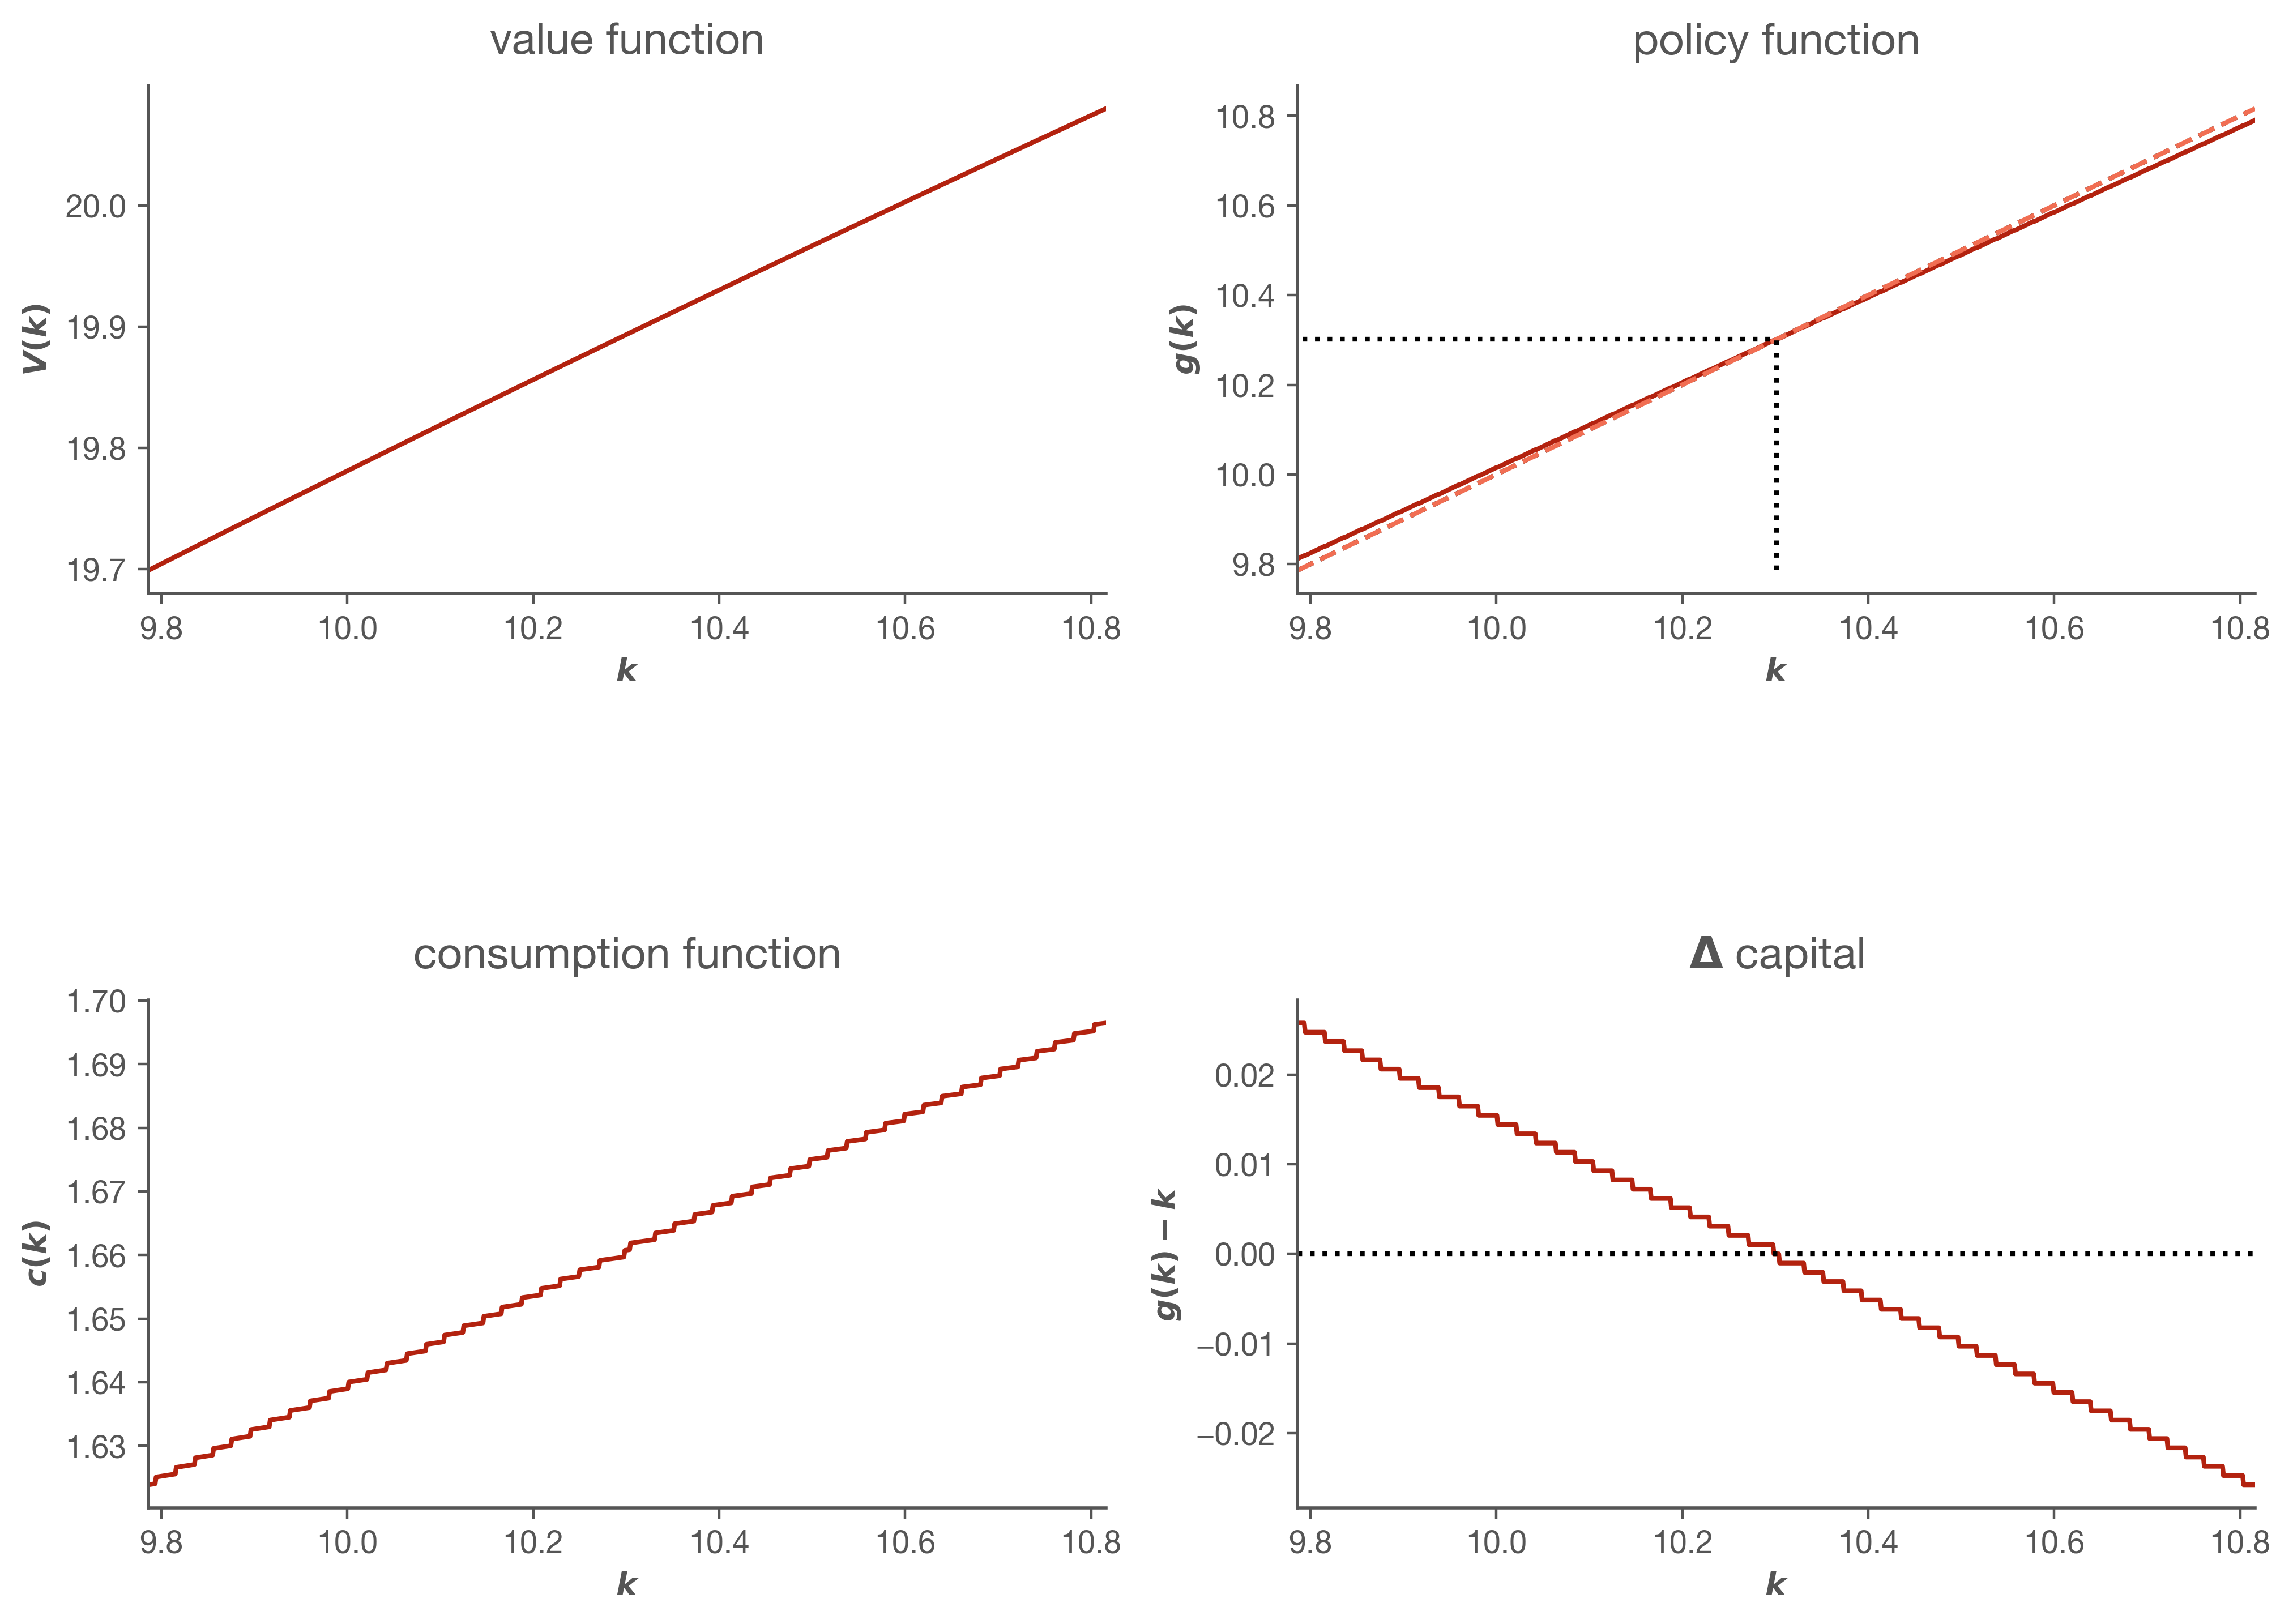

In [5]:
fig = VF_iteration_NGM_plot_figure(k_grid_vec,k_ss_vec, V_new_vec, g_new_vec, c_vec)
plt.show()

Now we do a larger grid:

Finshed at iteration 652
Vectorized iterations finished after 652 iterations, 12.097389 seconds.


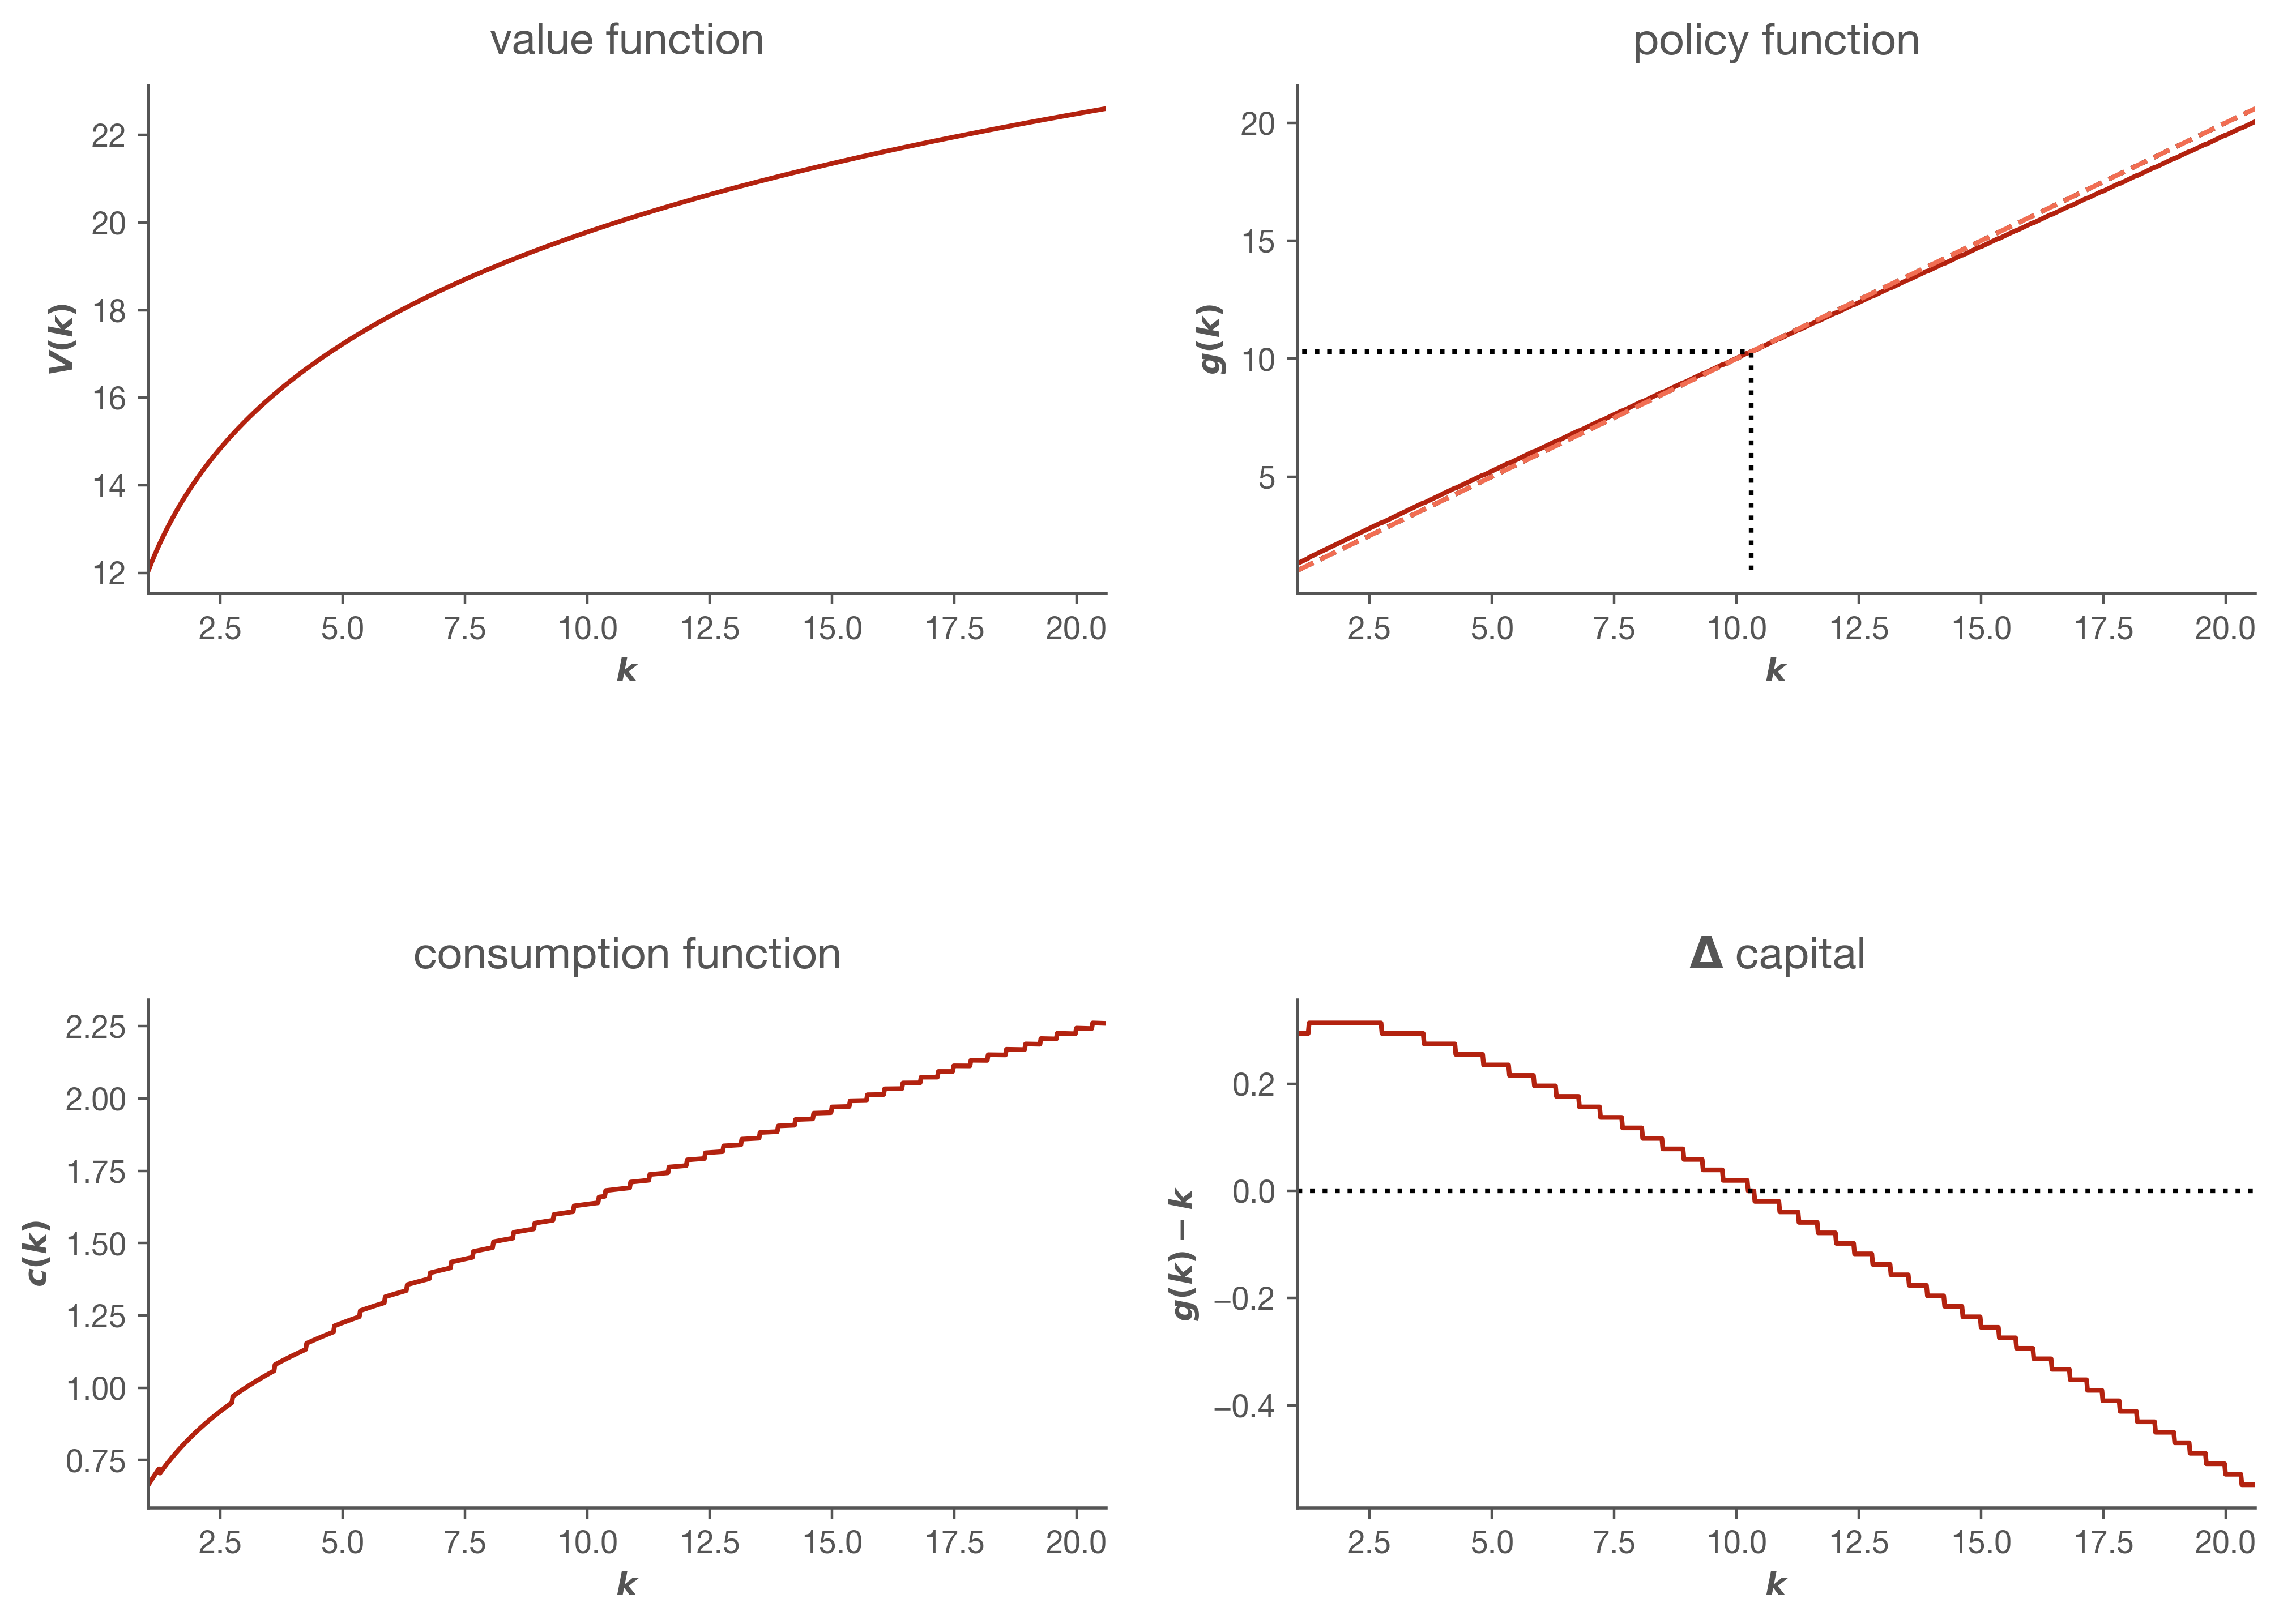

In [6]:
# Larger grid
params["k_grid"] = np.linspace(.1*k_ss,2*k_ss,nodes)

k_grid_iter, k_ss_iter, V_new_iter, g_new_iter, c_iter, param_iter= VFI_iteration_NGM_vectorized(params)

fig = VF_iteration_NGM_plot_figure(k_grid_iter,k_ss_iter, V_new_iter, g_new_iter, c_iter)
plt.show()

We look at higher depreciation levels:


Finshed at iteration 664
Vectorized iterations finished after 664 iterations, 14.217139 seconds.


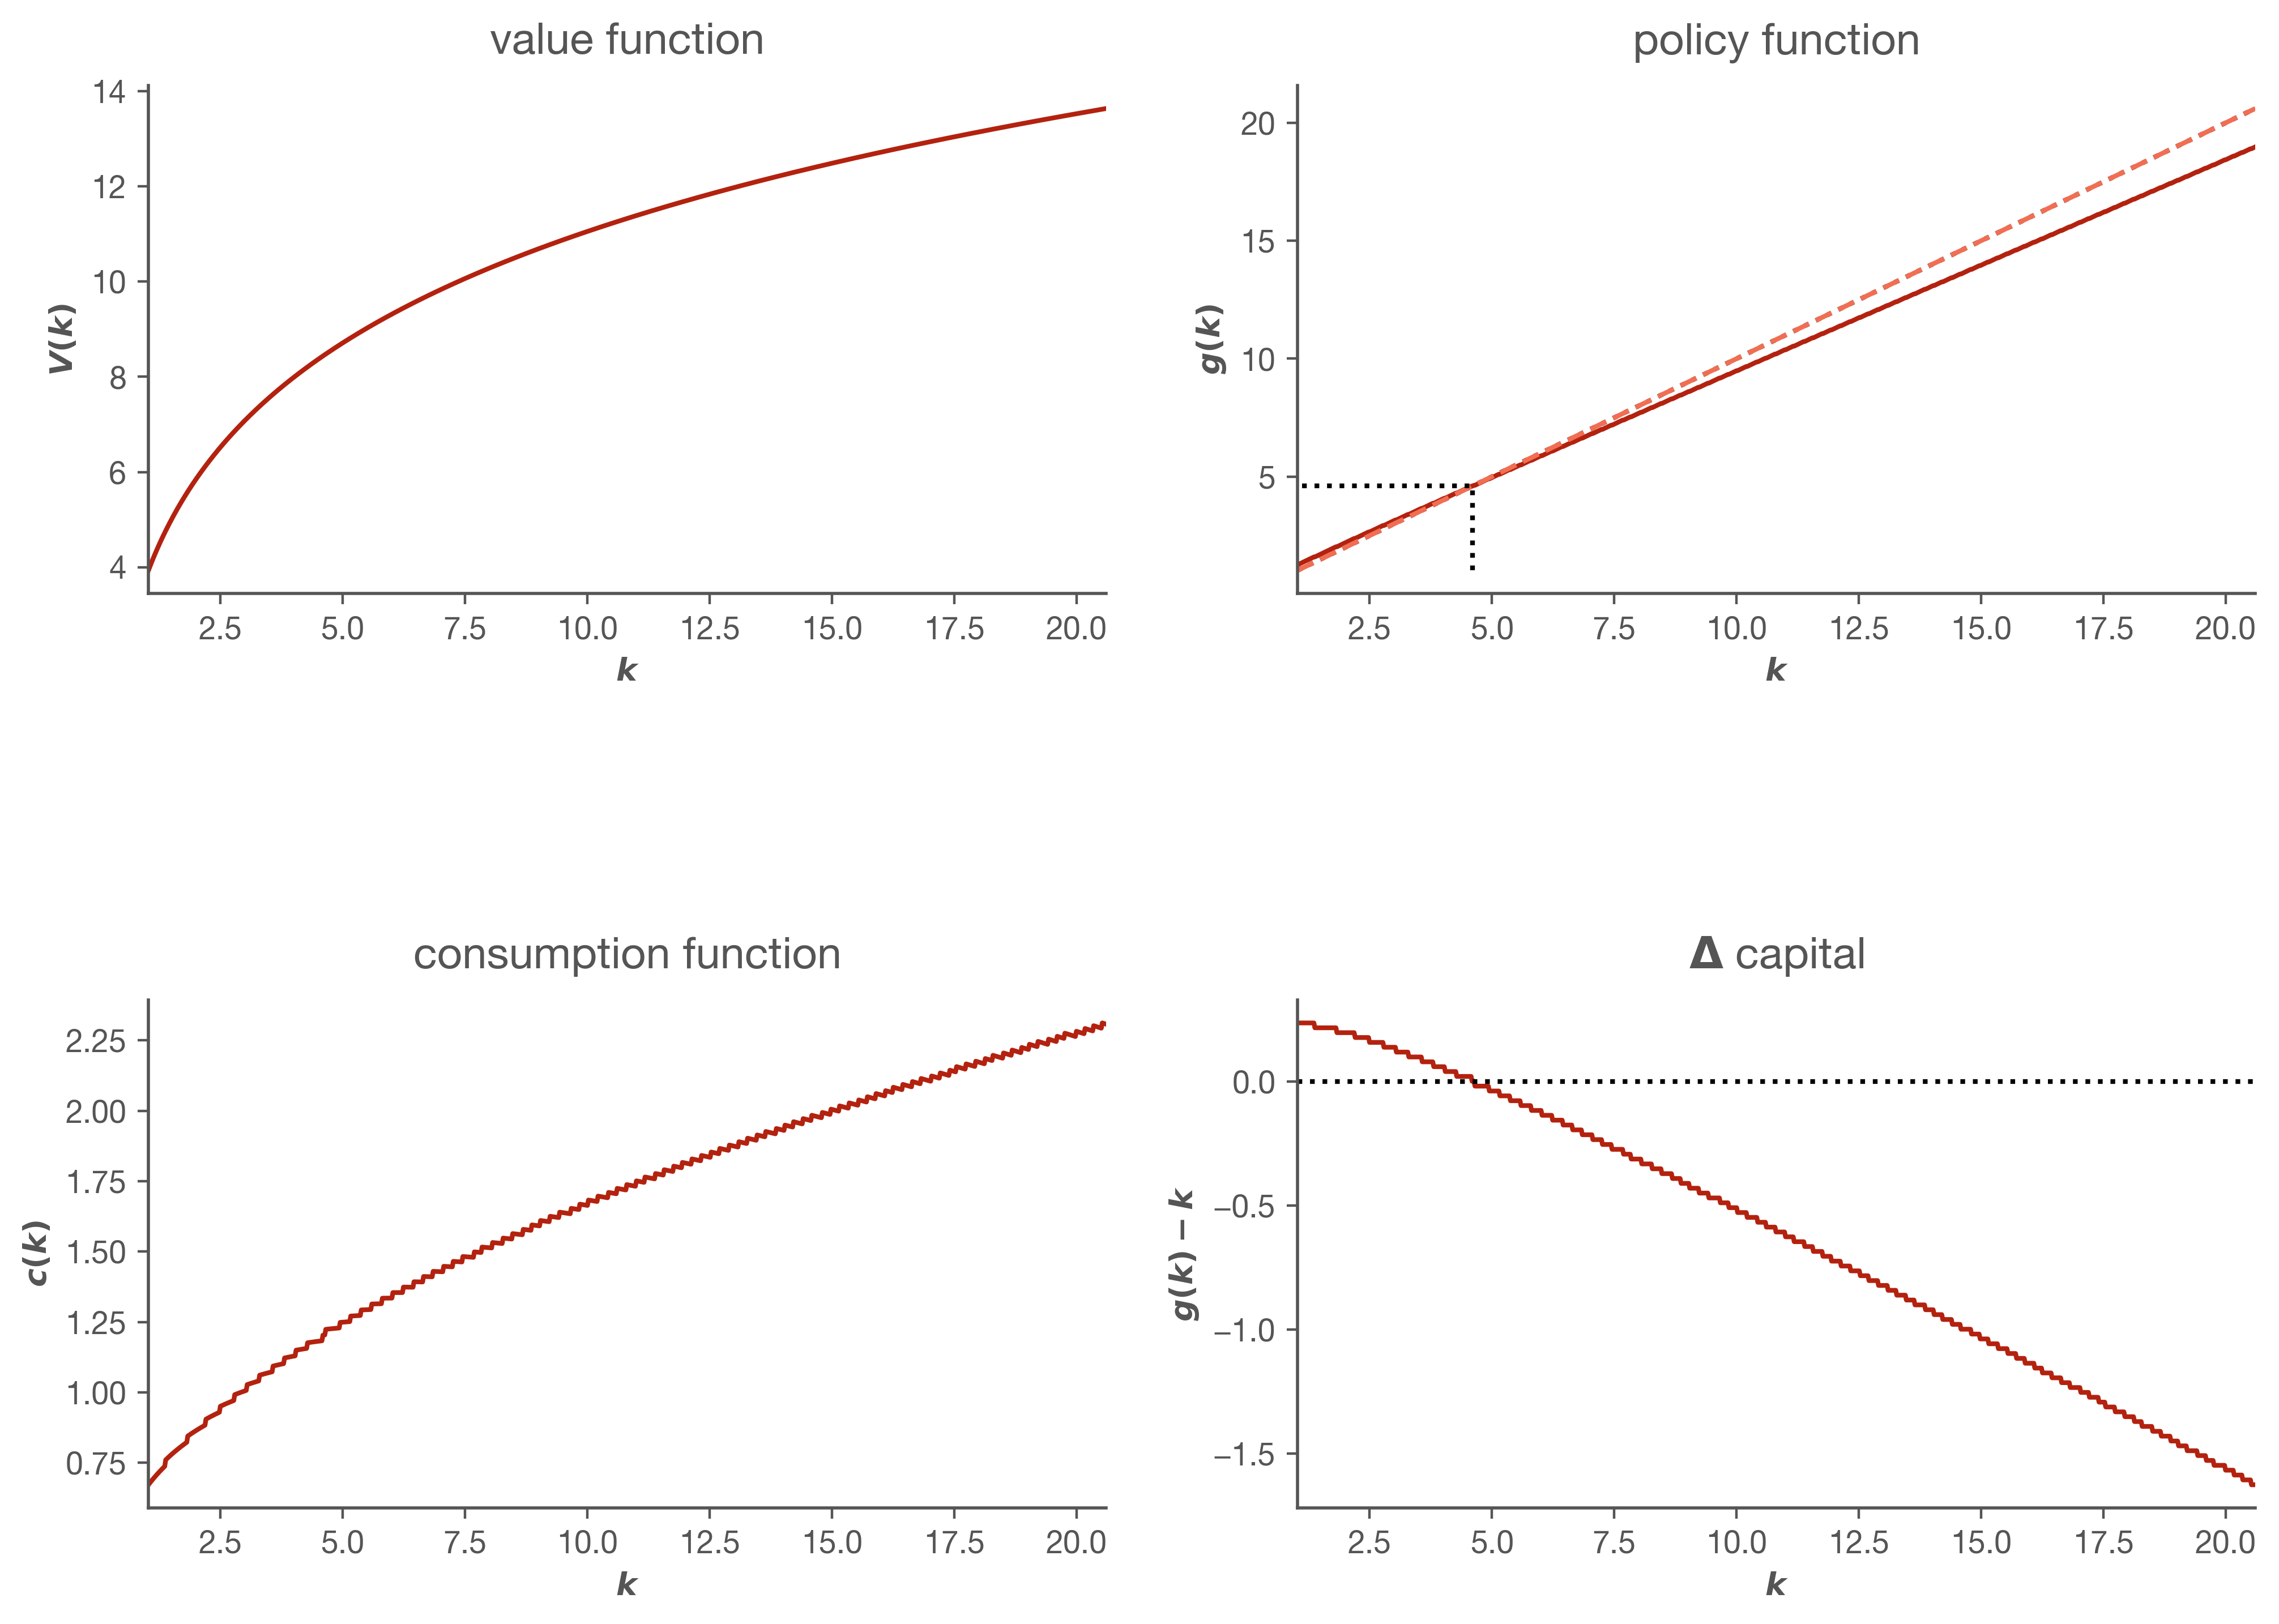

In [7]:
params = params_reset
params["DELTA"] = 0.1
k_grid, k_ss, V_new, g_new, c, param= VFI_iteration_NGM_vectorized(params)

fig = VF_iteration_NGM_plot_figure(k_grid,k_ss, V_new, g_new, c)
plt.show()

More impatience

Finshed at iteration 261
Vectorized iterations finished after 261 iterations, 5.236887 seconds.


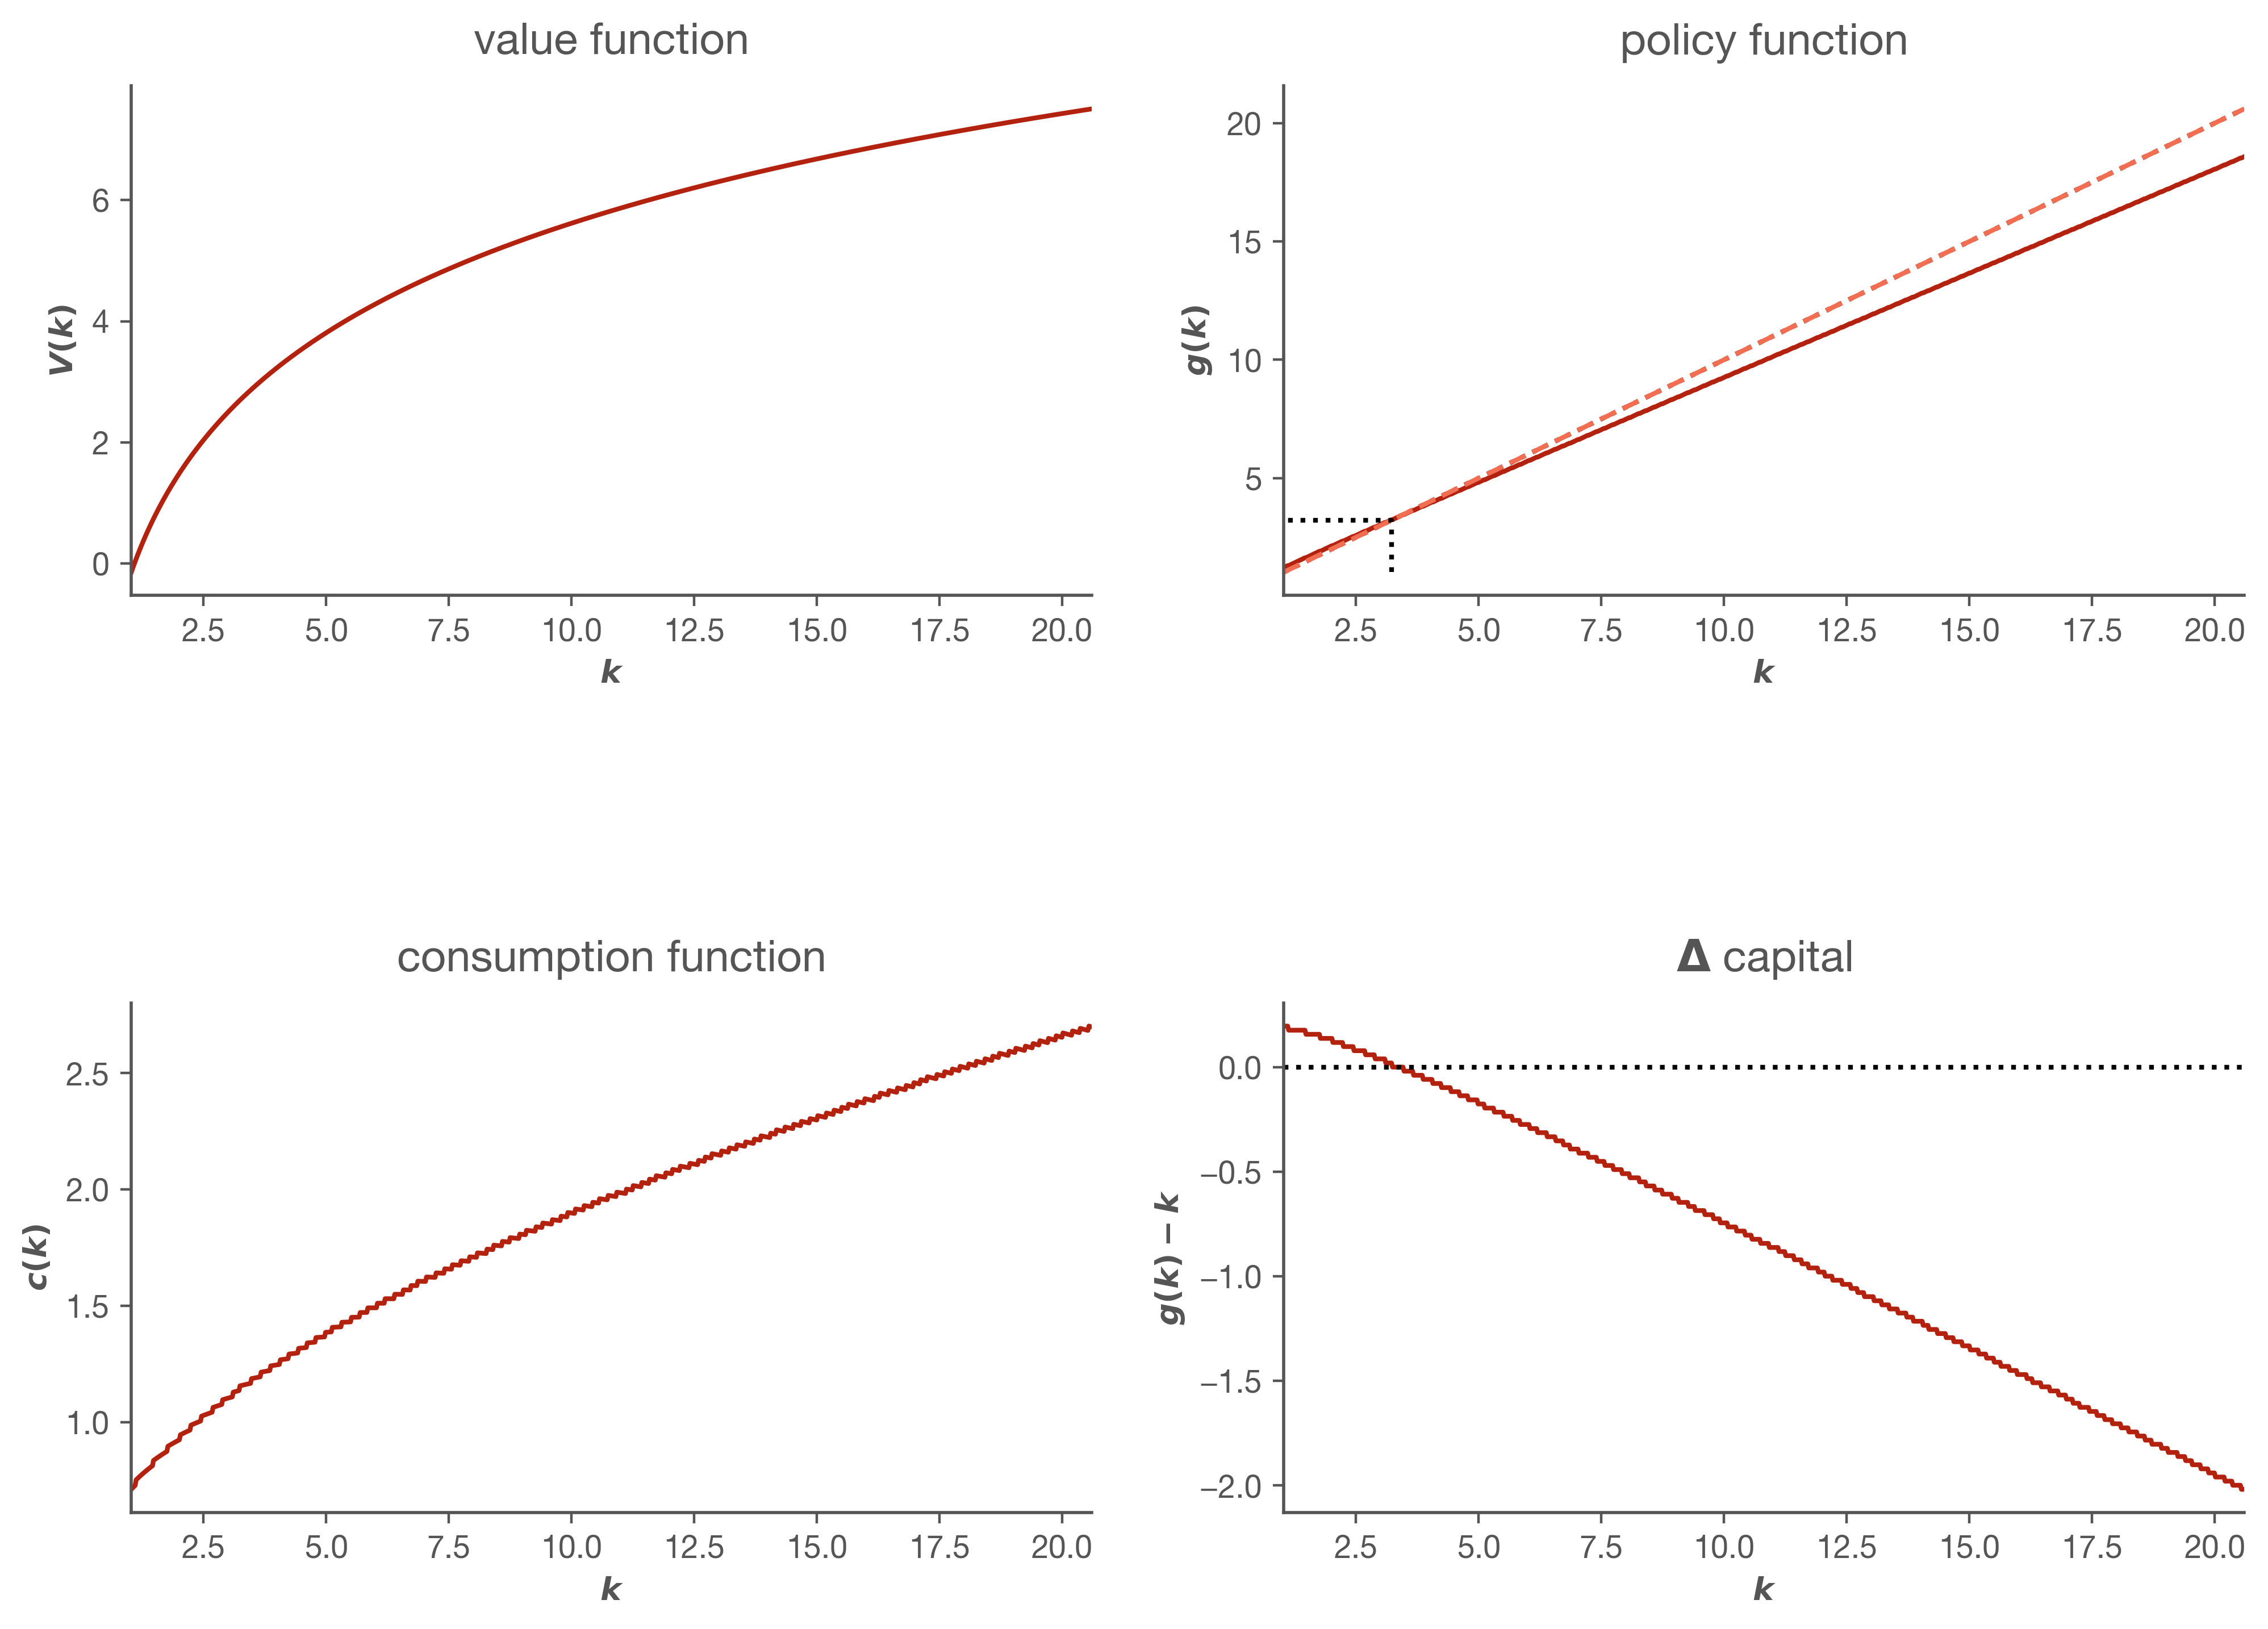

In [8]:
params = params_reset
params["BETA"] = 0.95
k_grid, k_ss, V_new, g_new, c, param= VFI_iteration_NGM_vectorized(params)

fig = VF_iteration_NGM_plot_figure(k_grid,k_ss, V_new, g_new, c)
plt.show()

Higher capital share (with adjusted grid to make steady state interior):

Finshed at iteration 252
Vectorized iterations finished after 252 iterations, 5.616245 seconds.


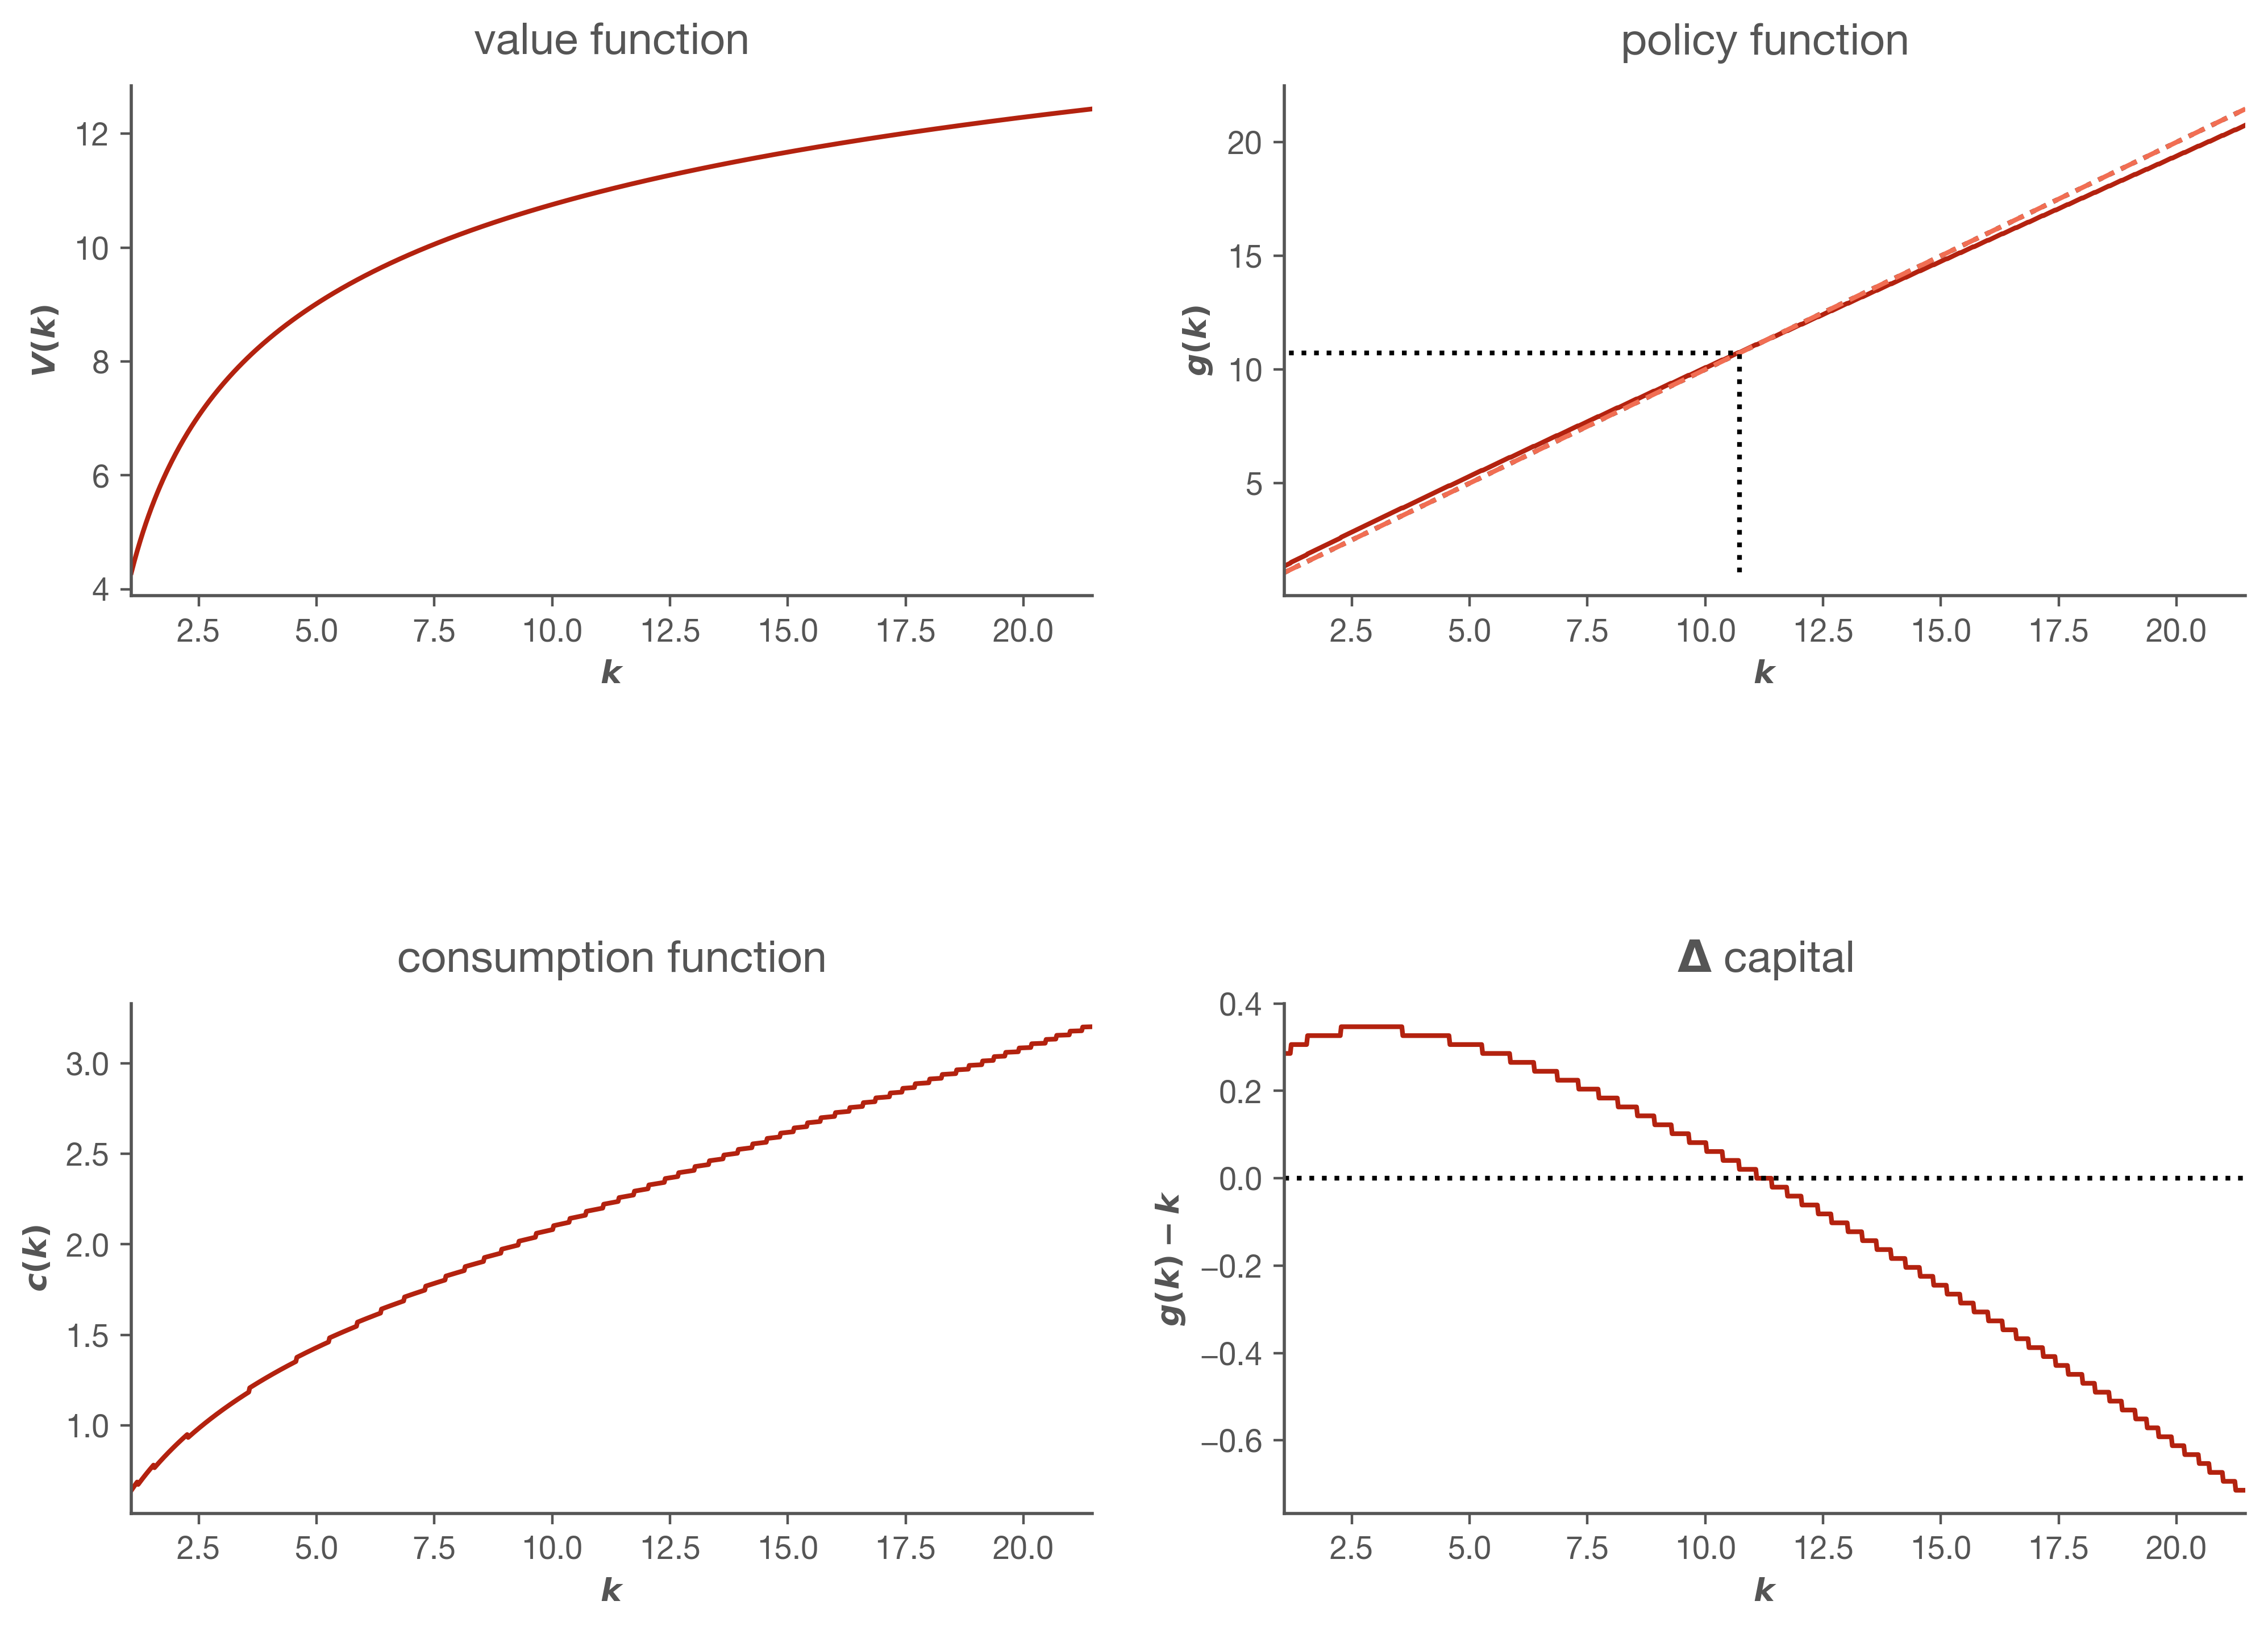

In [9]:
params = params_reset
params["ALPHA"] = 1/2
k_ss =  (params["ALPHA"]*params["A"]/(1/params["BETA"]-1+params["DELTA"]))**(1/(1-params["ALPHA"]))
params["k_grid"] = np.linspace(0.1*k_ss, 2*k_ss, nodes)
k_grid, k_ss, V_new, g_new, c, param= VFI_iteration_NGM_vectorized(params)

fig = VF_iteration_NGM_plot_figure(k_grid,k_ss, V_new, g_new, c)
plt.show()


Lower IES

Finshed at iteration 228
Vectorized iterations finished after 228 iterations, 5.138577 seconds.


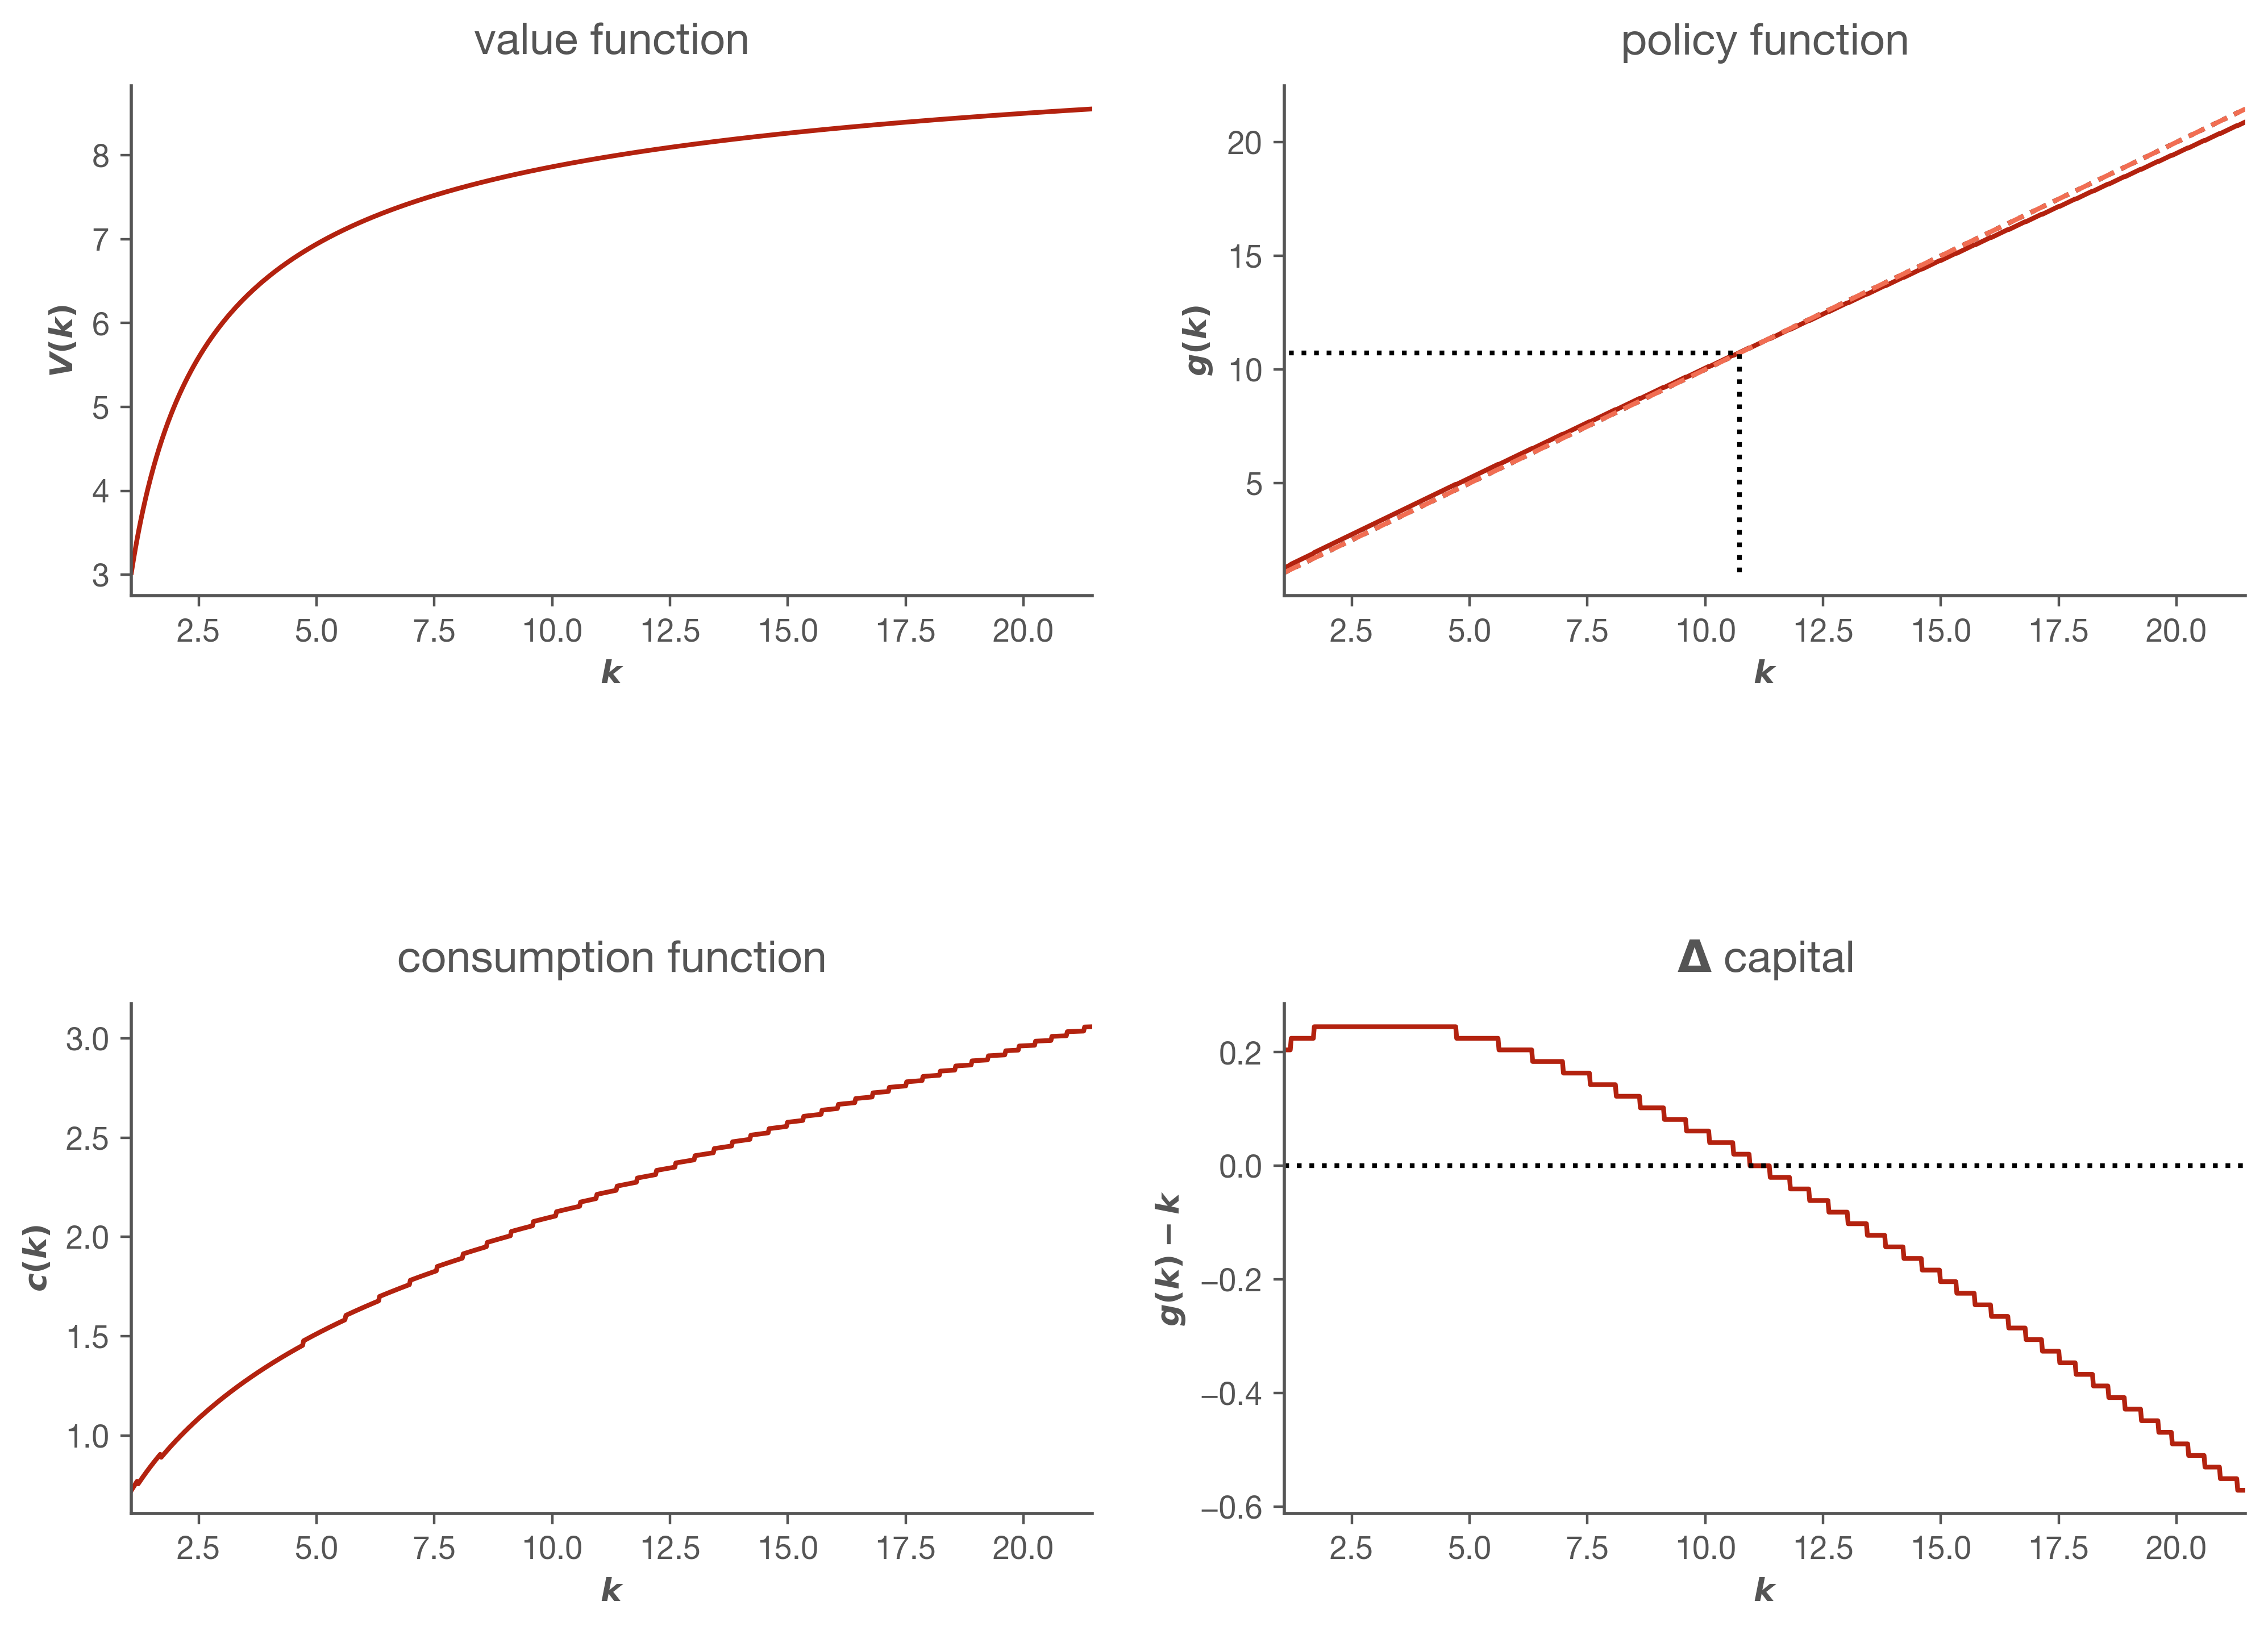

In [10]:
params = params_reset
params["GAMMA"] = 3
k_grid, k_ss, V_new, g_new, c, param= VFI_iteration_NGM_vectorized(params)

fig = VF_iteration_NGM_plot_figure(k_grid,k_ss, V_new, g_new, c)
plt.show()


Now we try interpolating the policy rule for comparison instead and updating the value function using this interpolation

In [11]:
import scipy.interpolate as interp 

def VFI_iteration_NGM_interp(param: dict):
    '''
    Algorithm for value function iteration with interpolation 
    Inputs: 
        Dictionary of parameter values and grid. 
    Outputs:
        Grid, steady state value, value function, policy function, consumption and parameters.
    '''
    start_time = time.time()

    DELTA = param["DELTA"]
    BETA = param["BETA"]
    ALPHA = param["ALPHA"]
    GAMMA = param["GAMMA"]
    A = param["A"]
    
    
    k_ss = (ALPHA*A/(1/BETA-1+DELTA))**(1/(1-ALPHA))
    c_grid = param["c_grid"]
    k_grid = param["k_grid"]
    I = len(k_grid)
    J = len(c_grid)
    c_grid = c_grid.reshape((J,1))
    k_grid = k_grid.reshape((I,1))

    V_new = np.zeros(I)
    g_new = np.zeros(I)
    c_new = np.zeros(I)
    F = np.zeros((J,I))
    max_error = 10**(-6)
    iter_max = 1000
    kprime = ((A*k_grid.T)**ALPHA+(1-DELTA)*k_grid.T)- c_grid
    F = np.where(kprime>0, (np.tile(c_grid,(1,I))**(1-GAMMA)-1)/(1-GAMMA),-np.infty)

    
    iter_finish = False
    iter = 0
    index = np.empty((I,1))
    V_max = np.empty((I,I))
    Q = np.empty((I,I))
    k = k_grid.squeeze()
    while (~iter_finish):
        g_old = g_new
        V_old = V_new
        c_old = c_new
        Vinterp_func = interp.interp1d(k,(V_old), kind = 'linear', fill_value = 'extrapolate')
        Vinterp = Vinterp_func(kprime)
        Q = F + BETA * Vinterp
        Q_max = np.max(Q, axis=0)
        V_max = Q_max
        index = (F + BETA*V_old).argmax(axis = 0)
        V_new = V_max
        c_new = c_grid[index]
        g_new = A*k_grid**ALPHA + (1-DELTA)*k_grid - c_new
        if ((np.max(np.abs(g_new-g_old)) < max_error) and (np.max(np.abs(V_new-V_old)) < max_error) and (np.max(np.abs(c_new-c_old)) < max_error)):
            iter_finish = True
            print("Finshed at iteration {}".format(iter))
            break
        iter += 1
        if iter>iter_max:
            break

    print('Interpolated iterations finished after %d iterations, %f seconds.' % (iter,time.time()-start_time))
    g_new = g_new.squeeze()
    c = (A*k**ALPHA + (1-DELTA)*k - g_new)
    v = Q_max.squeeze()

    return k, k_ss, v, g_new, c, param

Finshed at iteration 250
Interpolated iterations finished after 250 iterations, 3.149228 seconds.


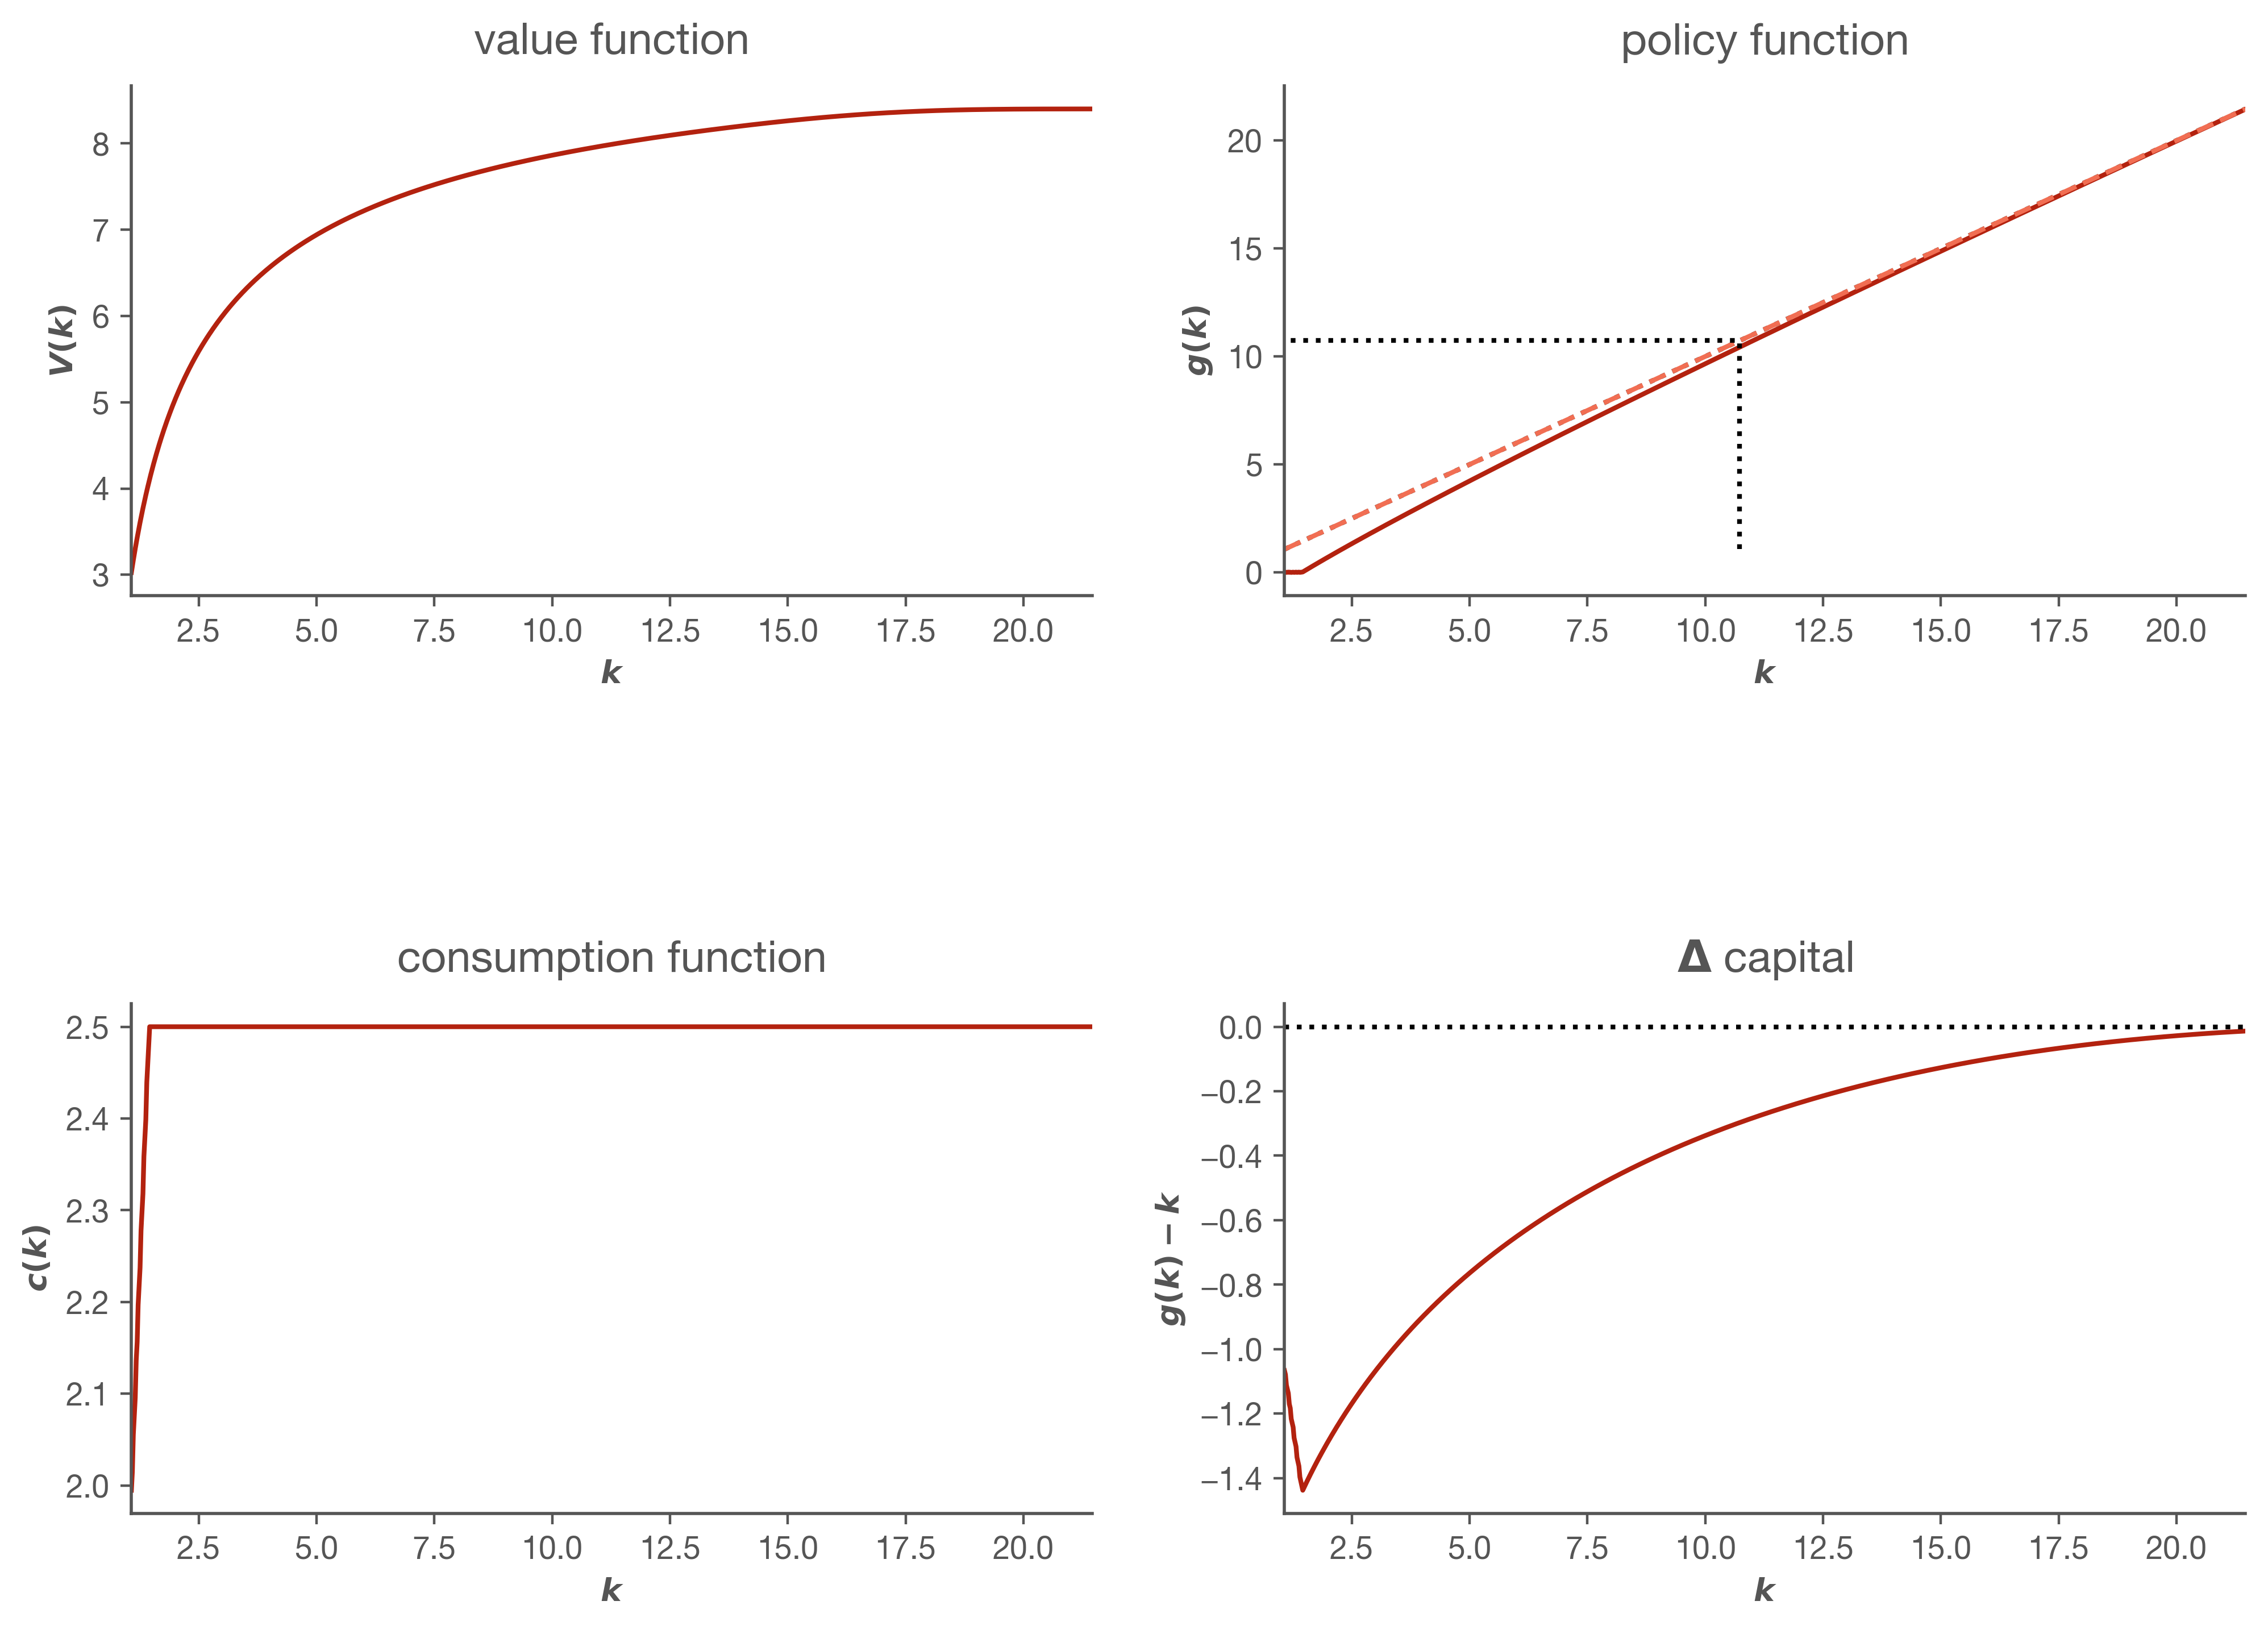

In [12]:
params=params_reset
params["k_grid"] = np.linspace(.1*k_ss,2*k_ss,nodes)

k_grid_interp, k_ss_interp, V_new_interp, g_new_interp, c_interp, param= VFI_iteration_NGM_interp(params)




fig = VF_iteration_NGM_plot_figure(k_grid_interp,k_ss_interp, V_new_interp, g_new_interp, c_interp)
plt.show()

### Question 2

Next we run the shooting method

In [13]:
δ=0.05
β=0.98
α=1/3
γ=2
A=1
T= 300
params = {
    "DELTA": δ,
    "BETA": β,
    "ALPHA": α,
    "GAMMA": γ,
    "T": T
}

def f(A,k,α):
    return A*k**α

k_ss=((1/β +δ -1)/(A*α))**(1/(α-1))
k0=0.25*k_ss

def knext(kt,ktp1):
    return -((1-δ)*kt + f(A,kt,α) - ktp1)*(β*((α*A*ktp1**(α-1))+1-δ))**(1/γ) + f(A,ktp1,α) + (1-δ)*ktp1
def cpath(kpath, params_arg = params):
    α = params["ALPHA"]
    β = params["BETA"]
    δ = params["DELTA"]
    γ = params["GAMMA"]
    T = params["T"]
    '''
    Computes path of consumption given a path of capital via budget constraint of household.
    '''
    return (f(A,kpath[0:T,:],α)+(1- δ)*kpath[0:T,:] - kpath[1:T+1,:])
    


def shooting(k0,k1,params_arg = params):
    α = params["ALPHA"]
    β = params["BETA"]
    δ = params["DELTA"]
    γ = params["GAMMA"]
    T = params["T"]
    kpath=np.zeros((T+1,np.size(k1)),dtype=np.float64)
    kpath[0,:]=k0*np.ones((1,np.size(k1)))
    kpath[1,:]=k1
    for t in range(2,T+1):
        kpath[t,:] = knext(kpath[t-2,:],kpath[t-1,:])
    return kpath
def tvcpath(kpath,params_arg = params):
    α = params["ALPHA"]
    β = params["BETA"]
    δ = params["DELTA"]
    γ = params["GAMMA"]
    T = params["T"]
    TVC = np.zeros((T,np.size(kpath[0,:])))
    for t in range(0,T):
        TVC[t,:] = (β**t)*(kpath[t,:]) * ((1-δ) + A*α*kpath[t,:]**(α-1))*((1-δ)*kpath[t,:] + A * kpath[t,:]**α - kpath[t+1,:])**(-γ)
    return TVC
def bisection (k0,k1,T=300,tol=1e-12, max_iter=1000, k_ter=0, params = params):
    k1 =np.array([k1])
    k1=k1.reshape((1,np.size(k1)))
    α = params["ALPHA"]
    β = params["BETA"]
    δ = params["DELTA"]
    γ = params["GAMMA"]
    T = params["T"]
    k1_upper=(f(A,k0,α)+(1-δ)*k0)
    k1_lower=0* np.ones((1,np.size(k1)))
    err=1
    count=0
    transv=np.zeros((T+1,np.size(k1)))
    k_ter = 0 * np.ones((1,np.size(k1)))
    k1 = (k1_upper+k1_lower)/2
    kpath = shooting(k0,k1,T)
    transv = tvcpath(kpath)
    err = transv[T-1,:]-k_ter
    while (np.amax(np.abs(err))>tol or np.any(np.isnan(err))) and count<max_iter:
        count=count+1
        kbool: np.ndarray = np.isnan(kpath)
        
        if np.any(kpath<0) or np.any(kbool):
            k1_lower=k1
            k1=(k1_lower+k1_upper)/2
            kpath = shooting(k0,k1,T)
            transv= tvcpath(kpath)
        else:
            k1_upper=k1
            k1 = (k1_upper+k1_lower)/2
            kpath = shooting(k0,k1,T)
            transv = tvcpath(kpath)
        err = transv[T-1,:]
    return k1

We then compute the optimal k1 value and perturb it via some deviations around it.

In [14]:
k1star= bisection(0.25*k_ss,.1*k_ss)
k1_dev = np.array([[-0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01]])

ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:80: RuntimeWarning: invalid value encountered in less


We then compute the optimal and perturbed paths of TVC, consumption and capital.

In [ ]:
k1_sub = k1_dev + k1star
kpathopt = shooting(0.25*k_ss,k1star)
kpaths_new = shooting(.25*k_ss, k1_sub)
cpathopt = cpath(kpathopt)
cpaths = cpath(kpaths_new)
tvcstar= tvcpath(kpathopt)
tvcpaths = tvcpath(kpaths_new)
c_ss = f(A,k_ss,α)+(1- δ)*k_ss - k_ss
k_ss_vec = np.repeat(k_ss,np.size(kpathopt)).reshape((np.size(kpathopt),1))
tvcpath_ss = tvcpath(k_ss_vec)

ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power


Finally we plot the optimal and perturbed paths

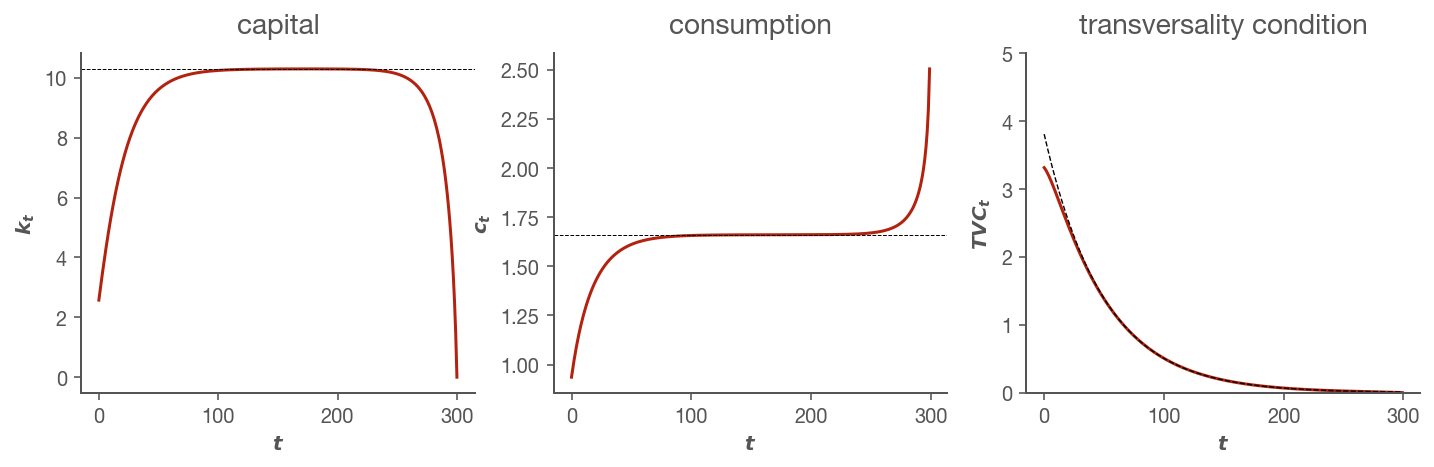

In [ ]:
#optimal paths
fig = plt.figure()
fig.set_size_inches(12, 3)
plt.subplot(1,3,1)
plt.plot(kpathopt,)
plt.axhline(k_ss, linestyle = '--', color='k',linewidth = .5)
plt.xlabel('$t$')
plt.ylabel('$k_t$')
plt.title('capital')
plt.subplot(1,3,2)
plt.plot(cpathopt,)
plt.axhline(c_ss, linestyle = '--', color='k',linewidth = .5)
plt.xlabel('$t$')
plt.ylabel('$c_t$')
plt.title('consumption')
plt.subplot(1,3,3)
plt.plot(tvcstar[0:T+1], )
plt.plot(tvcpath_ss, linestyle = '--', color='k',linewidth = .7)

plt.ylim([0, 5])
plt.xlabel('$t$')
plt.ylabel('$TVC_t$')
plt.title('transversality condition')
plt.show()

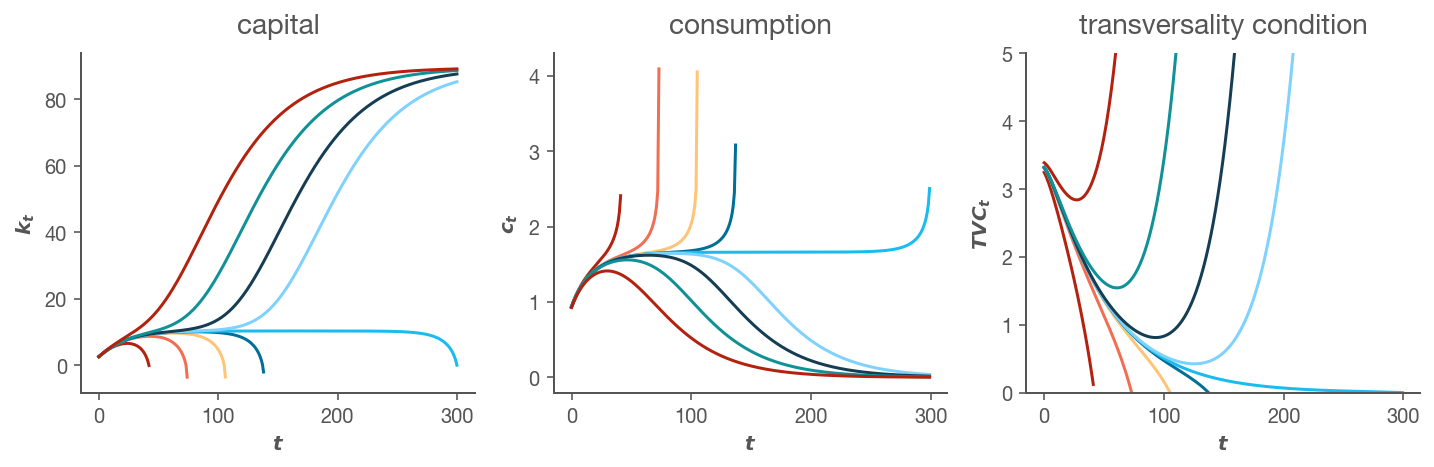

In [ ]:
fig = plt.figure()
fig.set_size_inches(12, 3)

plt.subplot(1,3,1)
for i in range(0,np.size(k1_dev)):
    plt.plot(kpaths_new[0:T+1,i].T, )
plt.xlabel('$t$')
plt.ylabel('$k_t$')
plt.title('capital')
plt.subplot(1,3,2)
for i in range(0,np.size(k1_dev)):
    plt.plot(cpaths[0:T+1,i].T,)
plt.xlabel('$t$')
plt.ylabel('$c_t$')
plt.title('consumption')

plt.subplot(1,3,3)
for i in range(0,np.size(k1_dev)):
    plt.plot(tvcpaths[0:T+1,i].T, )
plt.xlabel('$t$')
plt.ylabel('$TVC_t$')
plt.ylim([0,5])

plt.title('transversality condition')
plt.show()




Now we compare the plots of the shooting method and the two VFI methods. We load a convenience function first.

In [ ]:
def VF_iteration_NGM_plot_path(k_grid, g_new, c, k0):
    '''
    Convenience function to compute path of c,k.
    '''
    T = 500
    k_path = np.zeros((T+2,1))
    c_path = np.zeros((T+1,1))

    k_path[0] = k0

    Fg = interp.interp1d(k_grid, g_new, kind = 'linear', fill_value='extrapolate')
    Fc = interp.interp1d(k_grid, c, kind = 'linear', fill_value='extrapolate')

    for t in range(T+1):
        c_path[t] = Fc(k_path[t])
        k_path[t+1] = Fg(k_path[t])
    return c_path, k_path

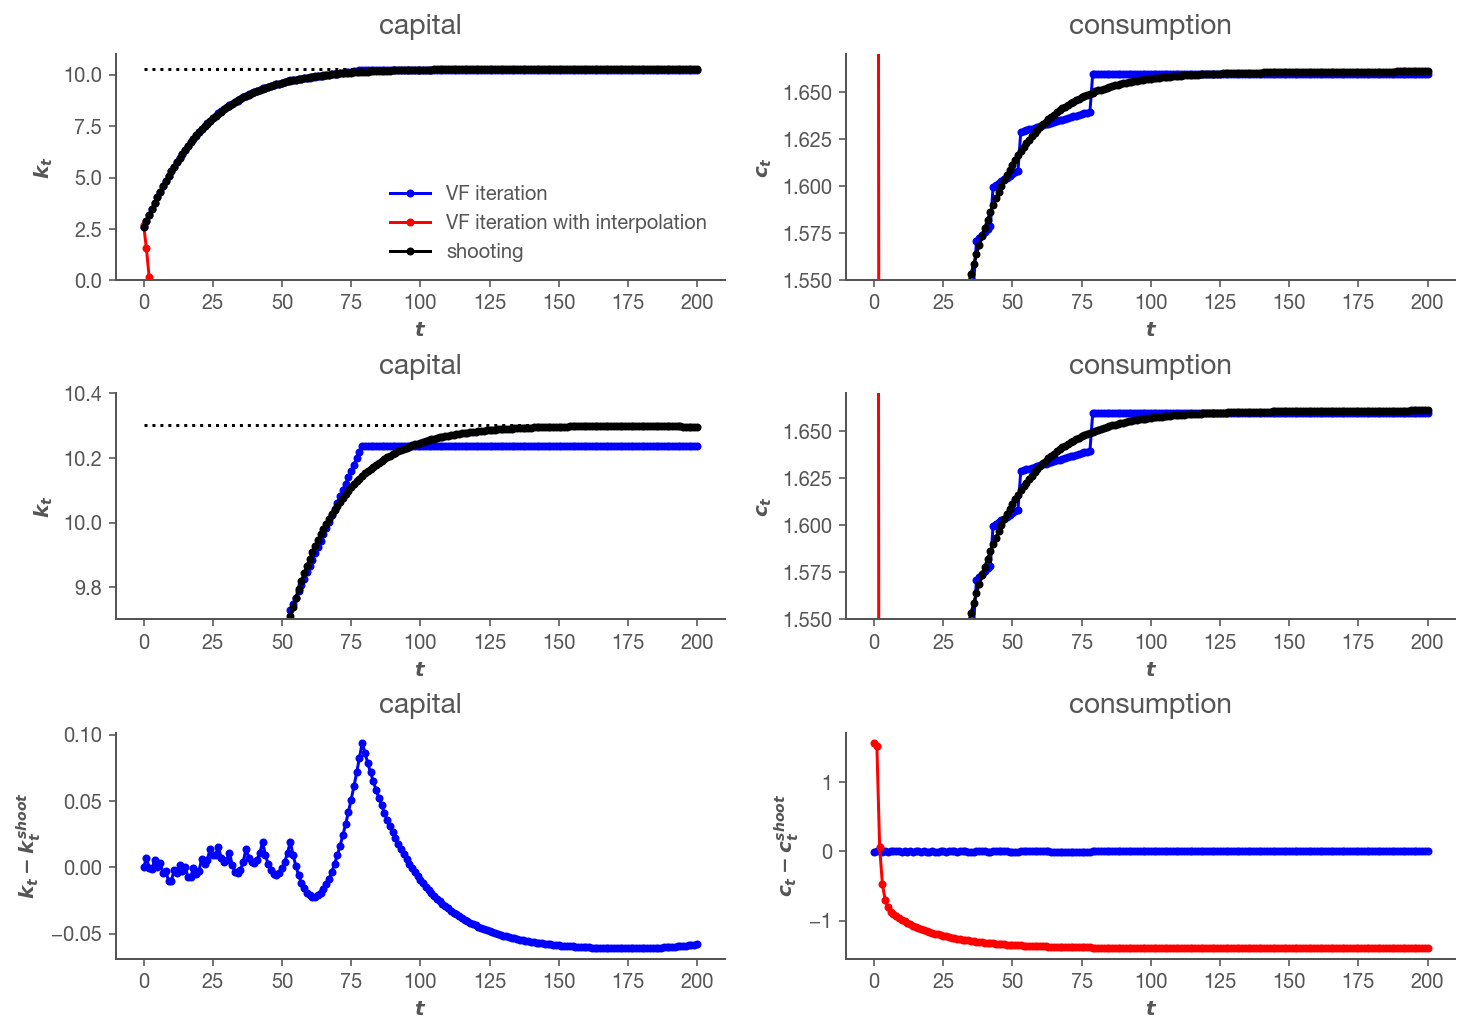

In [ ]:
T_plot = 200
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(3,2,1)
c_iter_path,k_iter_path = VF_iteration_NGM_plot_path(k_grid_iter, g_new_iter, c_iter, .25 * k_ss_iter) 
c_interp_path,k_interp_path = VF_iteration_NGM_plot_path(k_grid_interp, g_new_interp, c_interp, .25 * k_ss_interp) 
ax1.plot(k_iter_path[0:T_plot+1], 'b.-')
ax1.plot(k_interp_path[0:T_plot+1], 'r.-')
ax1.plot(kpathopt[0:T_plot+1], 'k.-')
ax1.plot([0, T_plot], [k_ss, k_ss], 'k:')
ax1.set_xlabel('$t$')
ax1.set_ylabel('$k_t$')
ax1.set_title('capital')
ax1.legend(['VF iteration', 'VF iteration with interpolation', 'shooting'], loc='lower right')
ax1.set_ylim([0, 11])

ax2 = fig.add_subplot(3,2,2)
ax2.plot(c_iter_path[0:T_plot+1], 'b.-')
ax2.plot(c_interp_path[0:T_plot+1], 'r.-')
ax2.plot(cpathopt[0:T_plot+1], 'k.-')
ax2.set_xlabel('$t$')
ax2.set_ylabel('$c_t$')
ax2.set_title('consumption')
ax2.set_ylim([1.55, 1.67])

ax3 = fig.add_subplot(3,2,3)
ax3.plot(k_iter_path[0:T_plot+1], 'b.-')
ax3.plot(k_interp_path[0:T_plot+1], 'r.-')
ax3.plot(kpathopt[0:T_plot+1], 'k.-')
ax3.plot([0, T_plot], [k_ss, k_ss], 'k:')
ax3.set_xlabel('$t$')
ax3.set_ylabel('$k_t$')
ax3.set_title('capital')
ax3.set_title('capital')
ax3.set_ylim([9.7, 10.4])

ax4 = fig.add_subplot(3,2,4)
ax4.plot(c_iter_path[0:T_plot+1], 'b.-')
ax4.plot(c_interp_path[0:T_plot+1], 'r.-')
ax4.plot(cpathopt[0:T_plot+1], 'k.-')
ax4.set_xlabel('$t$')
ax4.set_ylabel('$c_t$')
ax4.set_title('consumption')
ax4.set_ylim([1.55, 1.67])

ax5 = fig.add_subplot(3,2,5)
ax5.plot(k_iter_path[0:T_plot+1]-kpathopt[0:T_plot+1], 'b.-')
#ax5.plot(k_interp_path[0:T_plot+1]-kpathopt[0:T_plot+1], 'r.-')
ax5.set_xlabel('$t$')
ax5.set_ylabel('$k_t-k_t^{shoot}$')
ax5.set_title('capital')

ax6 = fig.add_subplot(3,2,6)
ax6.plot(c_iter_path[0:T_plot+1]-cpathopt[0:T_plot+1], 'b.-')
ax6.plot(c_interp_path[0:T_plot+1]-cpathopt[0:T_plot+1], 'r.-')
ax6.set_xlabel('$t$')
ax6.set_ylabel('$c_t-c_t^{shoot}$')
ax6.set_title('consumption')
fig.subplots_adjust(hspace=.5)
plt.show()

We also plot the phase diagram from class below to better understand the dynamics at play in the problem!

#### Phase Diagram


In [ ]:
def k_isocline(k):
    return f(A,k,α)- δ*k

def k_evol_diff(k,c):
    '''
    Finds evolution of k at each point in phase space from budget constraint
    '''
    k_diff = f(A,k.T,α)-δ*k.T-c
    return k_diff
def u_prime(c):
    return c**(-γ)
def u_prime_inv(u):
   return u**(-1/γ)
def f_prime(k):
    return A*(α)*k**(α-1)
def c_evol_diff(k,c):
    '''
    Finds evolution of c at each point in phase space from euler equation
    '''
    rho = -np.log(β)
    c_diff = 1/γ*c*((f_prime(k.T)-δ-rho))
    return c_diff

ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:80: RuntimeWarning: invalid value encountered in less
ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:80: RuntimeWarning: invalid value encountered in less
ipykernel_launcher:15: RuntimeWarning: divide by zero encountered in power
ipykernel_launcher:21: RuntimeWarning: invalid value encountered in multiply


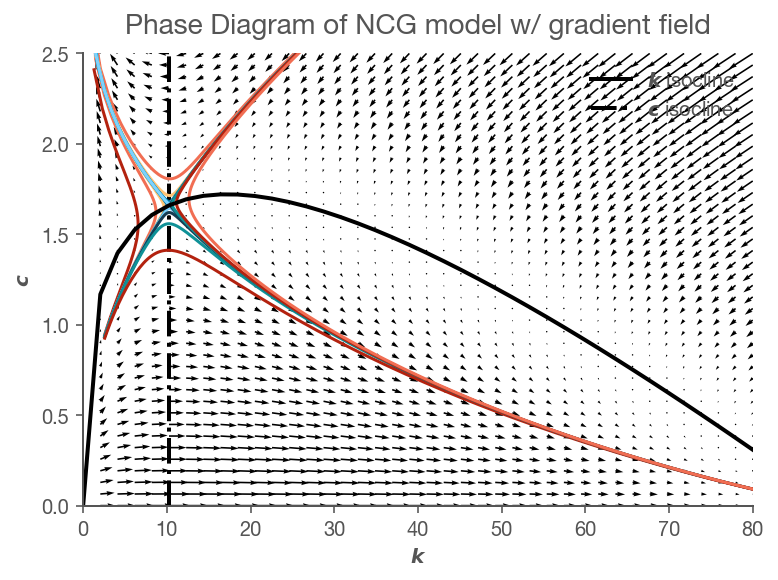

In [ ]:
k0 = .25*k_ss
k1star= bisection(k0,.1*k_ss)
k_grid = np.linspace(0,80,40).reshape((40,1))
c_grid = np.linspace(0,2.5,40).reshape((40,1))
k1_dev = np.array([[-0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01]])
k1_sub = k1_dev + k1star
kpathopt = shooting(k0,k1star)
kpaths_new = shooting(k0, k1_sub)
cpathopt = cpath(kpathopt)
cpaths = cpath(kpaths_new)
for i in range(0,np.size(k1_dev)):
    plt.plot(kpaths_new[0:T,i].T, cpaths[0:T+1,i])
k0 = 40*k_ss
k1star= bisection(k0,20*k_ss)
k1_dev = np.array([[-0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01]])
k1_sub = k1_dev + k1star
kpathopt = shooting(k0,k1star)
kpaths_new = shooting(k0, k1_sub)
cpathopt = cpath(kpathopt)
cpaths = cpath(kpaths_new)
for i in range(0,np.size(k1_dev)):
    plt.plot(kpaths_new[0:T,i].T, cpaths[0:T+1,i])
plt.ylim([0,2.5])
plt.xlim([0,80])
plt.vlines(k_ss,0, 3, label='$c$ isocline', linestyle = '-.', color = 'black', linewidth =2 )
plt.plot(k_grid,k_isocline(k_grid), color='black',label = '$k$ isocline', linewidth = 2)
#plots velocity arrows 
x_vals = k_evol_diff(k_grid,c_grid)
y_vals = c_evol_diff(k_grid,c_grid)
plt.quiver(k_grid,c_grid, x_vals, y_vals, angles='xy')


plt.title('Phase Diagram of NCG model w/ gradient field')
plt.xlabel('$k$')
plt.ylabel('$c$')
plt.legend()
plt.show()

ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:80: RuntimeWarning: invalid value encountered in less
ipykernel_launcher:22: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:16: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:56: RuntimeWarning: invalid value encountered in power
ipykernel_launcher:80: RuntimeWarning: invalid value encountered in less
ipykernel_launcher:15: RuntimeWarning: divide by zero encountered in power
ipykernel_launcher:21: RuntimeWarning: invalid value encountered in multiply


ValueError: setting an array element with a sequence.

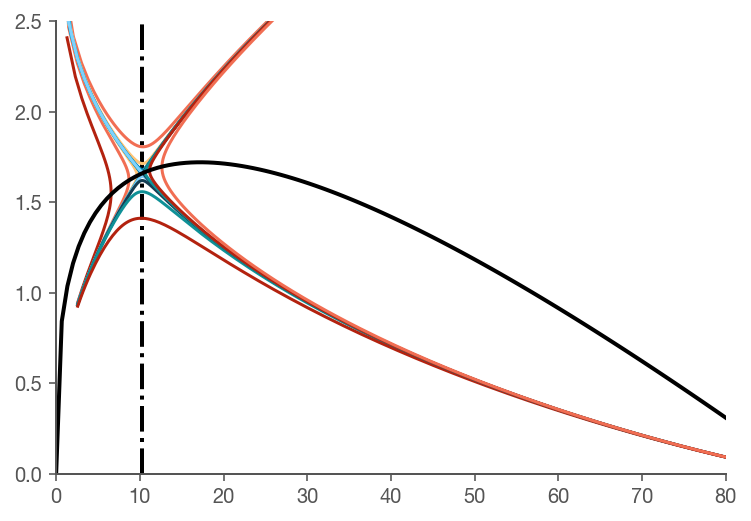

In [ ]:
k0 = .25*k_ss
k1star= bisection(k0,.1*k_ss)
k_grid = np.linspace(0,80,120).reshape((120,1))
c_grid = np.linspace(0,2.5,120).reshape((1,120))
k1_dev = np.array([[-0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01]])
k1_sub = k1_dev + k1star
kpathopt = shooting(k0,k1star)
kpaths_new = shooting(k0, k1_sub)
cpathopt = cpath(kpathopt)
cpaths = cpath(kpaths_new)
for i in range(0,np.size(k1_dev)):
    plt.plot(kpaths_new[0:T,i].T, cpaths[0:T+1,i])
k0 = 40*k_ss
k1star= bisection(k0,20*k_ss)
k1_dev = np.array([[-0.01, -0.001, -0.0001, -0.00001, 0, 0.00001, 0.0001, 0.001, 0.01]])
k1_sub = k1_dev + k1star
kpathopt = shooting(k0,k1star)
kpaths_new = shooting(k0, k1_sub)
cpathopt = cpath(kpathopt)
cpaths = cpath(kpaths_new)
for i in range(0,np.size(k1_dev)):
    plt.plot(kpaths_new[0:T,i].T, cpaths[0:T+1,i])
plt.ylim([0,2.5])
plt.xlim([0,80])
plt.vlines(k_ss,0, 3, label='$c$ isocline', linestyle = '-.', color = 'black', linewidth =2 )
plt.plot(k_grid,k_isocline(k_grid), color='black',label = '$k$ isocline', linewidth = 2)
#plots velocity arrows 
X,Y = np.meshgrid(k_grid,c_grid)
x_vals = k_evol_diff(X,Y)
y_vals = c_evol_diff(X,Y)
seed_points = np.array([[0, 5,7,8,9, 10, 20, 40, 60, 80],[.2,.4,.5, .6, .9, 1.0, 1.3, 1.7, 2.1, 2.5]])
plt.streamplot(X,Y, x_vals, y_vals, cmap='autumn', start_points = seed_points.T)




plt.title('Phase Diagram of NCG model, normalized arrows')
plt.xlabel('$k$')
plt.ylabel('$c$')
plt.legend()
plt.show()